# Import Required Libraries

In [1]:
import random
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score, roc_auc_score, log_loss,\
                            precision_score, recall_score, f1_score, brier_score_loss, classification_report,\
                            mean_squared_error, confusion_matrix,roc_curve ,precision_recall_curve,auc

In [2]:
%config Completer.use_jedi = False
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# Set Seed

In [4]:
seed_value = 9
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

<IPython.core.display.Javascript object>

# Read Required Data & Inputs

In [5]:
df = pd.read_csv('train.csv')
df_data = df.copy()
df_data.shape

(1460, 81)

# Data Config 

In [6]:
# Define Target Varible here 
Target = "SalePrice"

# Define Indetifier Columns
identifer_cols = ["SalePrice","Id"]


# Catogorical Variable
cat_cols = df_data.select_dtypes(['object']).columns.tolist()
cat_cols = [i for i in cat_cols if i not in identifer_cols]

# Numerical Variable
num_cols = df_data.select_dtypes([int, int32, int64, float]).columns.tolist()
num_cols = [i for i in num_cols if i not in cat_cols+identifer_cols]


# list of variables that contain year information
year_feature = [feature for feature in num_cols if 'Yr' in feature or 'Year' in feature]

# Discrete Variable
discrete_cols = [feature for feature in num_cols if len(df_data[feature].unique())<25]
discrete_cols = [i for i in discrete_cols if i not in year_feature]

num_cols = [i for i in num_cols if i not in cat_cols+identifer_cols+year_feature]

# Contionus Varible 
cont_cols = [x for x in num_cols if x not in discrete_cols+year_feature]

# Data Snapshot (Data Types, Missing Values etc)

In [7]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []
    
    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)
        
    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()
    
    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    pd.set_option('display.max_rows', None)
    print(variable_desc)

In [8]:
def statistical_info(df):
    try:
        display(df.describe(include=[np.number]).T)
    except:
        print("Data has no numerical varible")
    try:
        display(df.describe(include=[np.object]).T)
    except:
        print("Data has no object varible ")
    try:
        display(df.describe(include=[np.category]).T)
    except:
        print("Data has no category varible ")
        print()
    data_description(df)
    return 

In [9]:
statistical_info(df_data)

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


Data has no category varible 

Data description
Total number of records 1460
number of features 81


             Name     Type  Unique levels  Missing
0              Id    int64           1460        0
1      MSSubClass    int64             15        0
2        MSZoning   object              5        0
3     LotFrontage  float64            110      259
4         LotArea    int64           1073        0
5          Street   object              2        0
6           Alley   object              2     1369
7        LotShape   object              4        0
8     LandContour   object              4        0
9       Utilities   object              2        0
10      LotConfig   object              5        0
11      LandSlope   object              3        0
12   Neighborhood   object             25        0
13     Condition1   object              9        0
14     Condition2   object              8        0
15       BldgType   object              5        0
16     HouseStyle   object      

# Missing Values and Constant Columns 

In [10]:
def Missing_constant_columns(df):
    constant_cols = []
    features_with_na = [feature for feature in df.columns if df[feature].isnull().sum()>1]
    missing_features = [feature+" has "+str(np.round(df[feature].isna().mean(), 4))+"% Missing values %" for feature in features_with_na]
    
    for feature in df.select_dtypes(['float','int', 'int64', 'int32']).columns:
        if statistics.variance(df[feature])==0:
            constant_cols.append(feature)
    return missing_features,constant_cols

In [11]:
missing_features,constant_cols =  Missing_constant_columns(df_data)

In [12]:
missing_features

['LotFrontage has 0.1774% Missing values %',
 'Alley has 0.9377% Missing values %',
 'MasVnrType has 0.0055% Missing values %',
 'MasVnrArea has 0.0055% Missing values %',
 'BsmtQual has 0.0253% Missing values %',
 'BsmtCond has 0.0253% Missing values %',
 'BsmtExposure has 0.026% Missing values %',
 'BsmtFinType1 has 0.0253% Missing values %',
 'BsmtFinType2 has 0.026% Missing values %',
 'FireplaceQu has 0.4726% Missing values %',
 'GarageType has 0.0555% Missing values %',
 'GarageYrBlt has 0.0555% Missing values %',
 'GarageFinish has 0.0555% Missing values %',
 'GarageQual has 0.0555% Missing values %',
 'GarageCond has 0.0555% Missing values %',
 'PoolQC has 0.9952% Missing values %',
 'Fence has 0.8075% Missing values %',
 'MiscFeature has 0.963% Missing values %']

In [13]:
constant_cols

[]

# Independent Varible Snapshot

In [14]:
def Independenet_varible_Snapshot(df):
    print("Overall data snapshot")
    print("No of rows is ",df_data.shape[0],"and","No of Columns is",df_data.shape[1])
    display(df.head(2))
    try:
        print("cat_cols data snapshot")
        display(df[cat_cols].head(2))
    except:
        print("Data has no cat_cols")
    try:
        print("cont_cols data snapshot")
        display(df[cont_cols].head(2))
    except:
        print("Data has no cont_cols")
    try:
        print("discrete_cols data snapshot")
        display(df[discrete_cols].head(2))
    except:
        print("Data has no discrete_cols")
    try:
        print("date and time data snapshot")
        display(df[year_feature].head(2))
    except:
        print("Data has no year_feature")
        
    print("len of cat_cols is",len(cat_cols),
          "len of cont_cols is",len(cont_cols),
          "len of discrete_cols is",len(discrete_cols),
          "len of date_and_time_cols is",len(year_feature),
          "len of independent varaible",len(cat_cols)+len(cont_cols)+len(discrete_cols)+len(year_feature))
    return 
    

In [15]:
Independenet_varible_Snapshot(df_data)

Overall data snapshot
No of rows is  1460 and No of Columns is 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


cat_cols data snapshot


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


cont_cols data snapshot


,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,65.0,8450,196.0,706,0,150,856,856,854,1710,548,0,61,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0


discrete_cols data snapshot


,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold
0,60,7,5,0,1,0,2,1,3,1,8,0,2,0,0,0,2
1,20,6,8,0,0,1,2,0,3,1,6,1,2,0,0,0,5


date and time data snapshot


,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007


len of cat_cols is 43 len of cont_cols is 15 len of discrete_cols is 17 len of date_and_time_cols is 4 len of independent varaible 79


# Dependent varaible Statistical 

In [16]:
def Target_Varible_analysis(df,target):
    print("Median   ",df[target].median())
    display(df[target].describe(include=[np.object]).T)
    sns.distplot(df[target])
    plt.title('Plot For {}'.format(target))
    return

Median    163000.0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

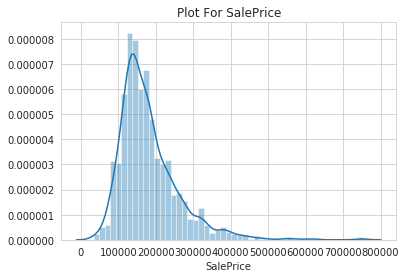

In [17]:
Target_Varible_analysis(df_data,Target)

# EDA and Data Cleaning on Continuous columns 

In [18]:
df_data[cont_cols].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,65.0,8450,196.0,706,0,150,856,856,854,1710,548,0,61,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,1786,608,0,42,0,0
3,60.0,9550,0.0,216,0,540,756,961,756,1717,642,0,35,272,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,2198,836,192,84,0,0


In [19]:
missing_features_cont,_ =  Missing_constant_columns(df_data[cont_cols])
missing_features_cont

['LotFrontage has 0.1774% Missing values %',
 'MasVnrArea has 0.0055% Missing values %']

# Visualization of Key Features on Continuous columns

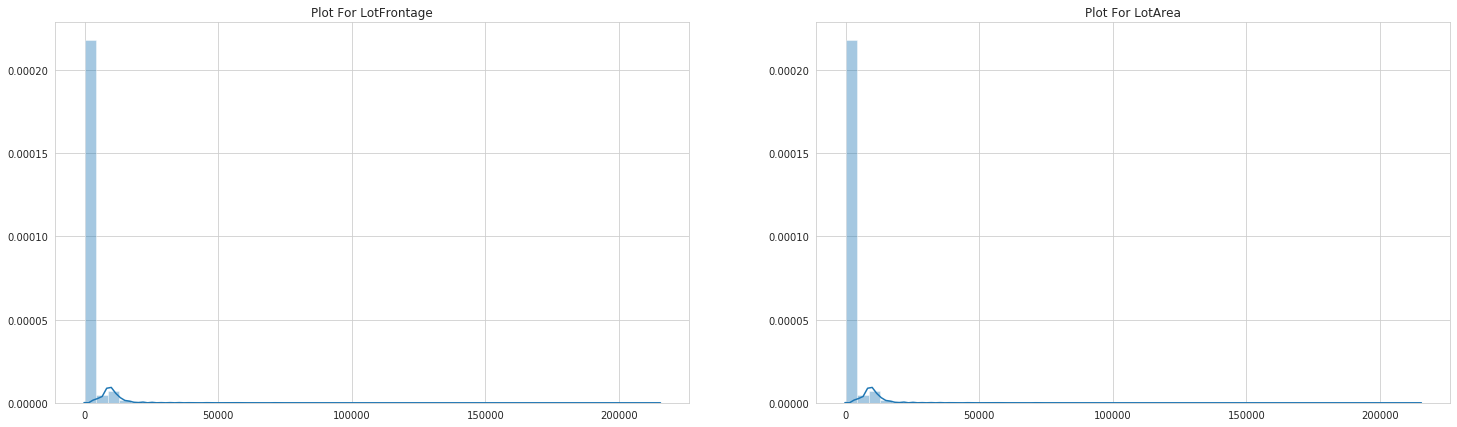

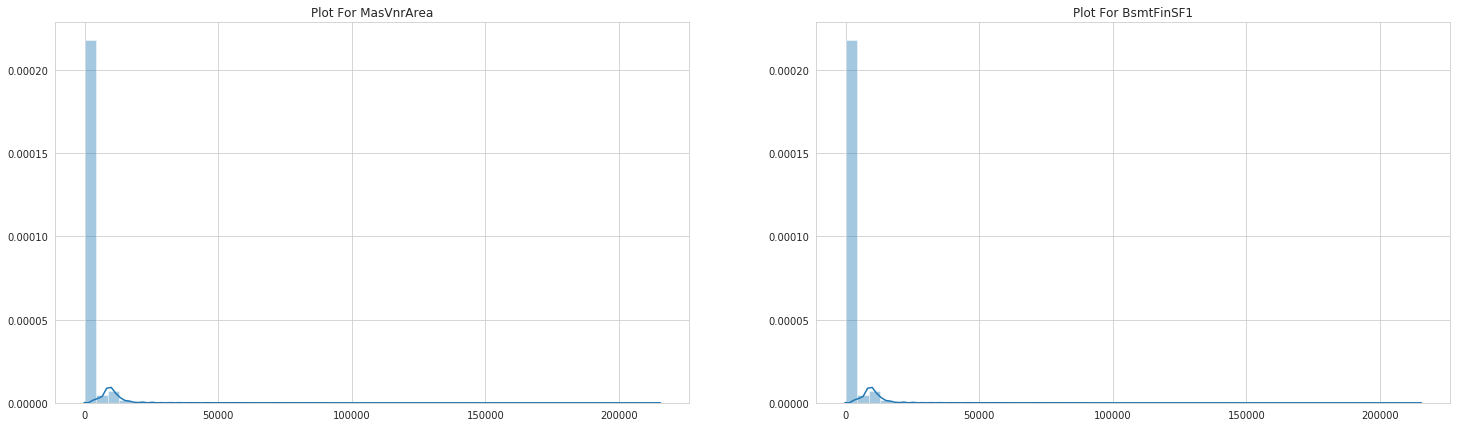

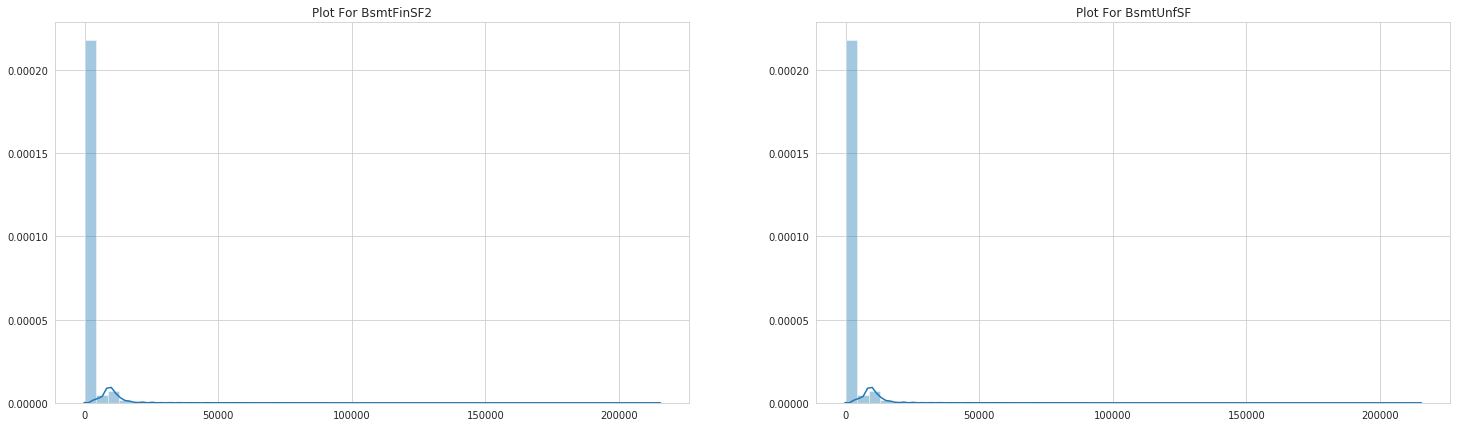

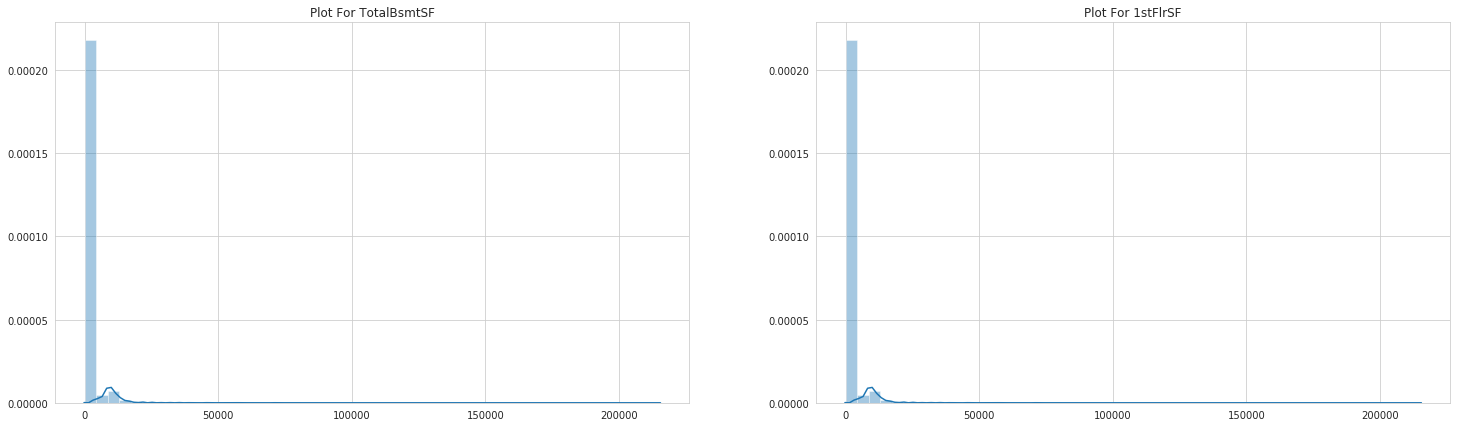

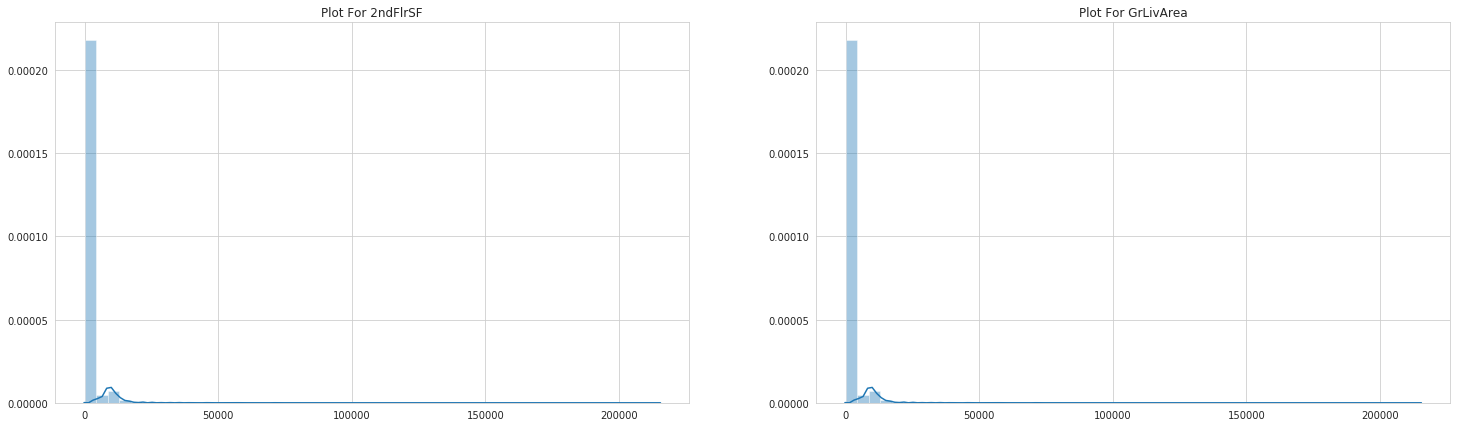

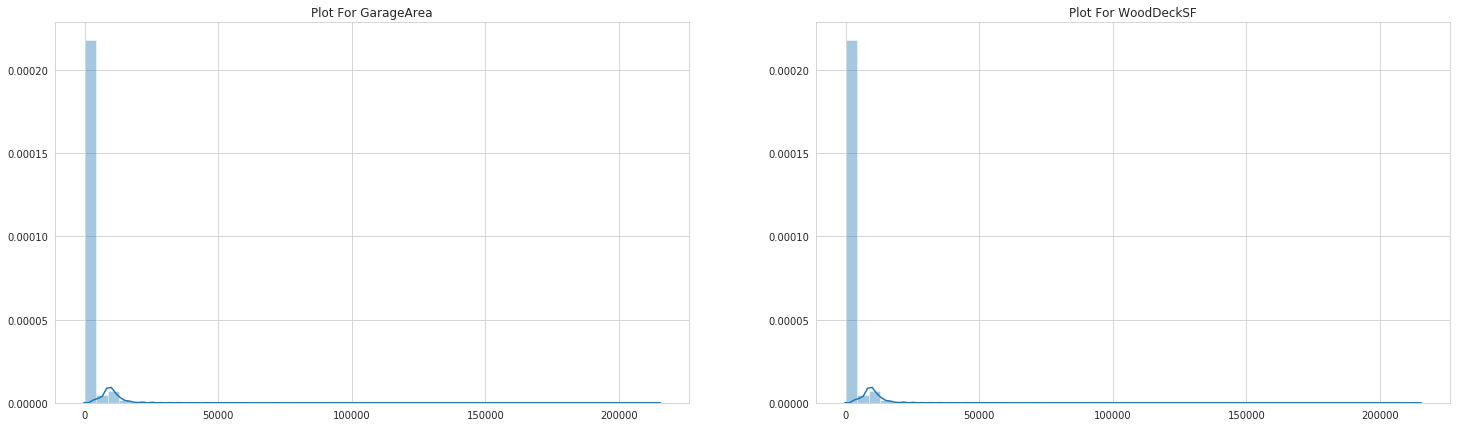

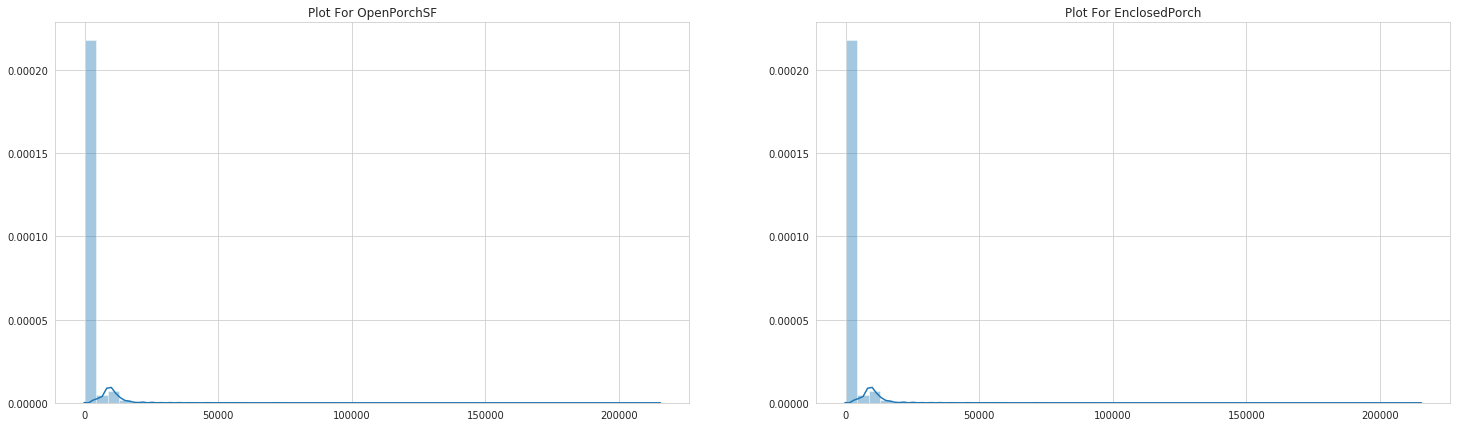

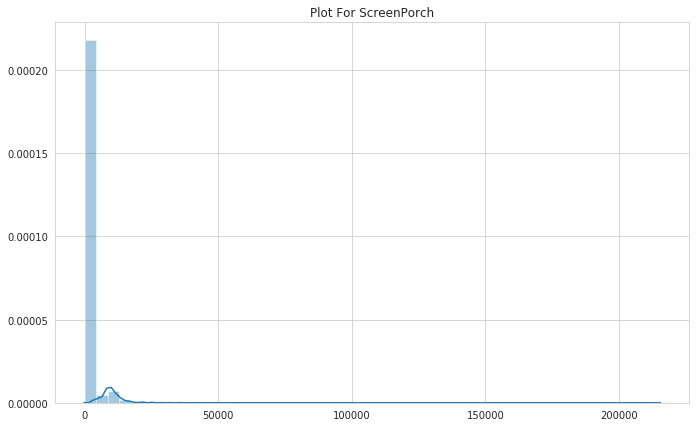

In [20]:
figures_per_time = 2
count = 0 

for cont_feature in cont_cols:
    try:
        plt.figure(count//figures_per_time,figsize=(25,7))
        plt.subplot(1,figures_per_time,np.mod(count,2)+1)
        sns.distplot(df_data[cont_cols])
        plt.title('Plot For {}'.format(cont_feature))
        count+=1
    except:
        pass

# Filling Missing value of Continuous columns

In [21]:
def Missing_value_impute_cont(df,feature,threshold):
        if df[feature].isnull().sum()>1:
            Missing_value_per = float(np.round(df[feature].isnull().mean(), 4))
            if Missing_value_per <= threshold:
                df[feature].fillna(df[feature].median(), inplace = True)
                print("filling missing value feature name is",feature,Missing_value_per)
            else:
                df.drop([feature],axis=1)
                print("Droping feature",feature,Missing_value_per,threshold)
        else:
            pass
        return df

In [22]:
for feature in df_data[cont_cols].columns:
    df_data = Missing_value_impute_cont(df_data,feature,0.3)

filling missing value feature name is LotFrontage 0.1774
filling missing value feature name is MasVnrArea 0.0055


In [23]:
missing_features_cont,_ =  Missing_constant_columns(df_data[cont_cols])
missing_features_cont

[]

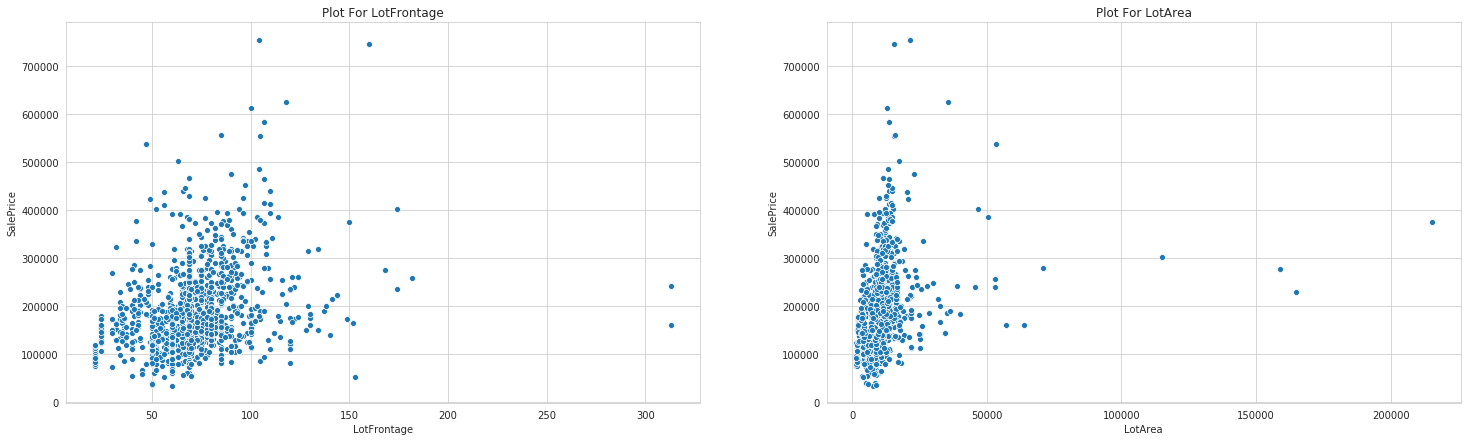

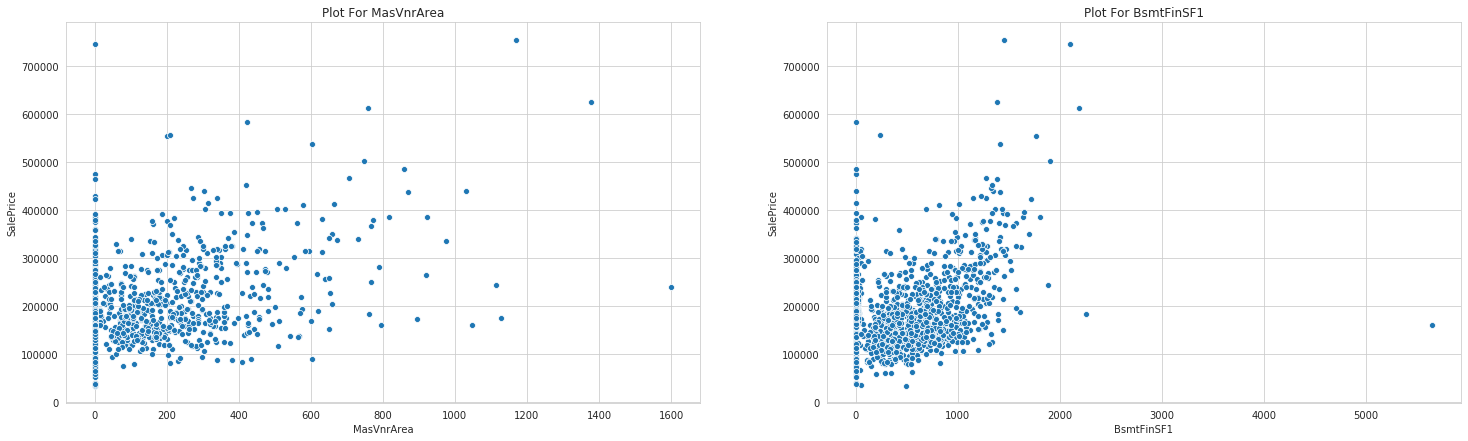

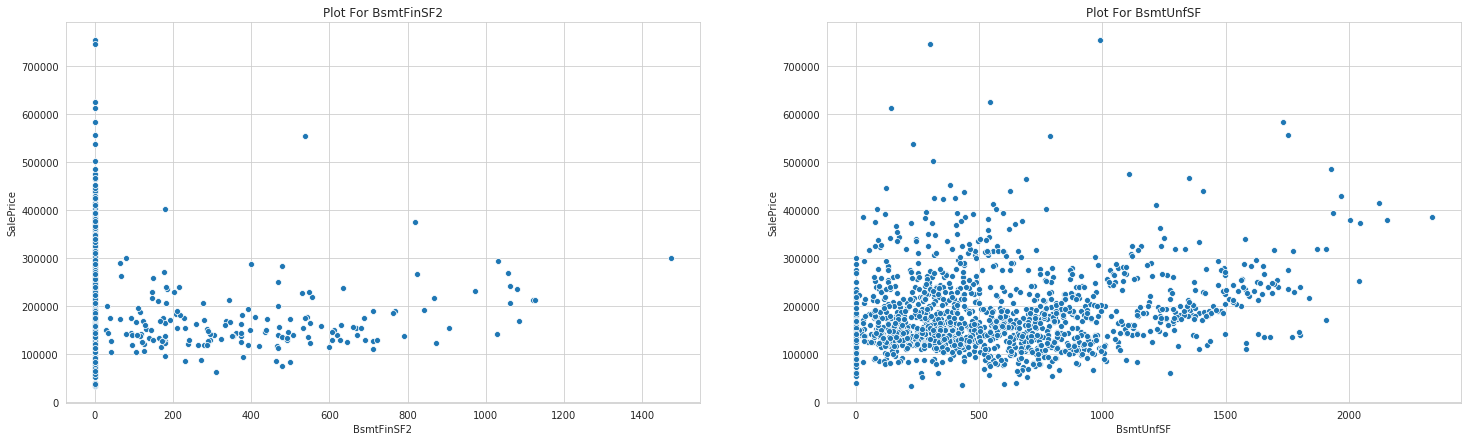

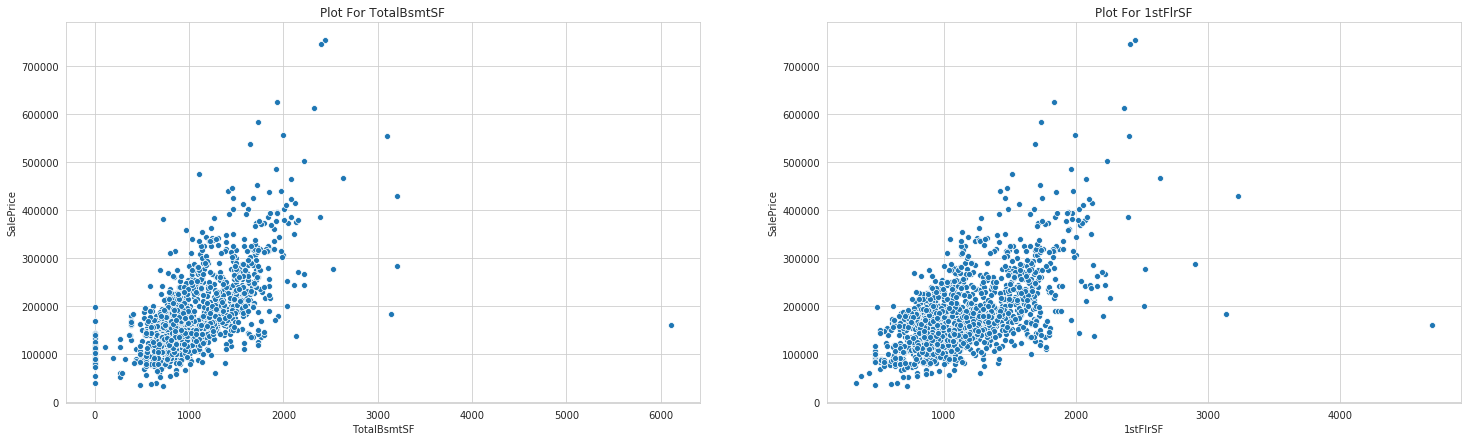

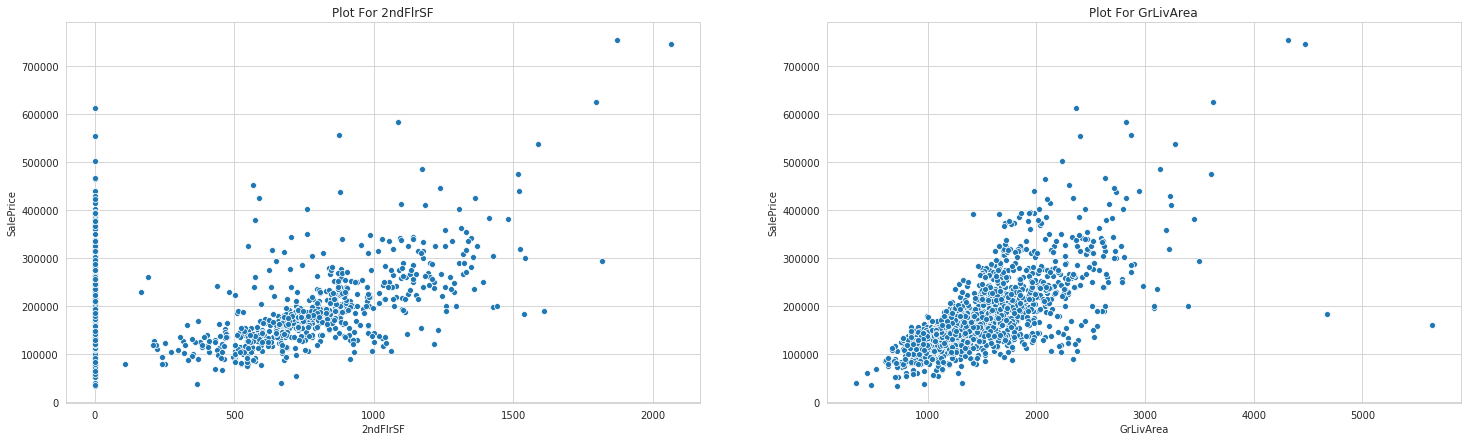

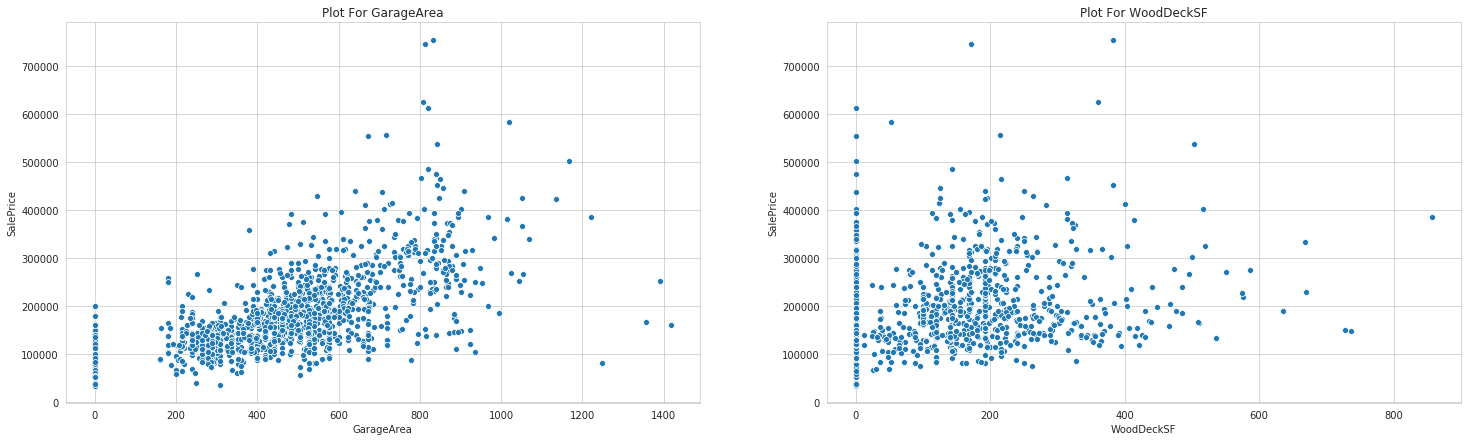

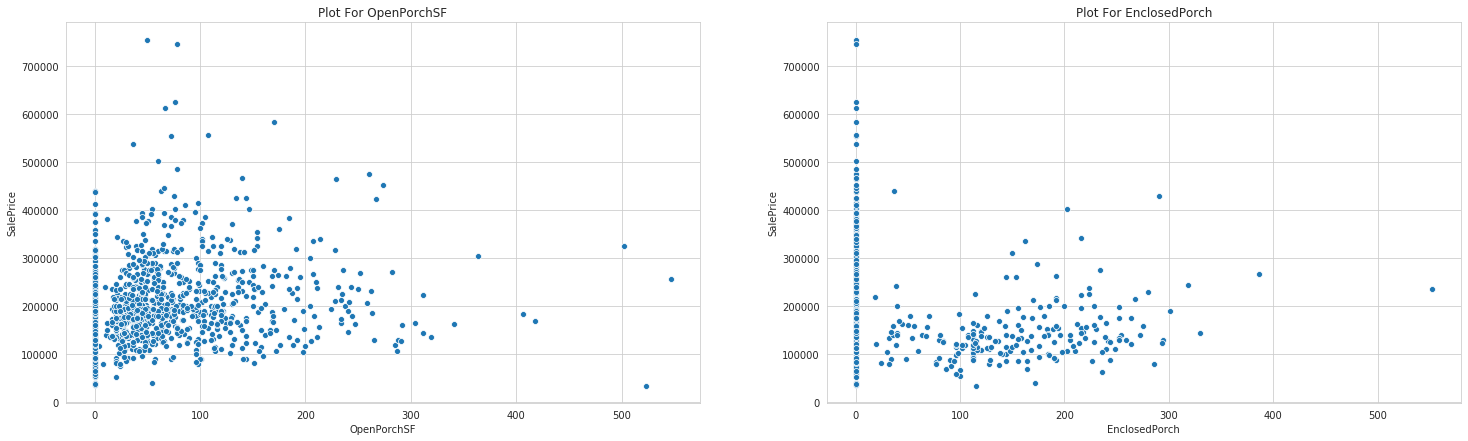

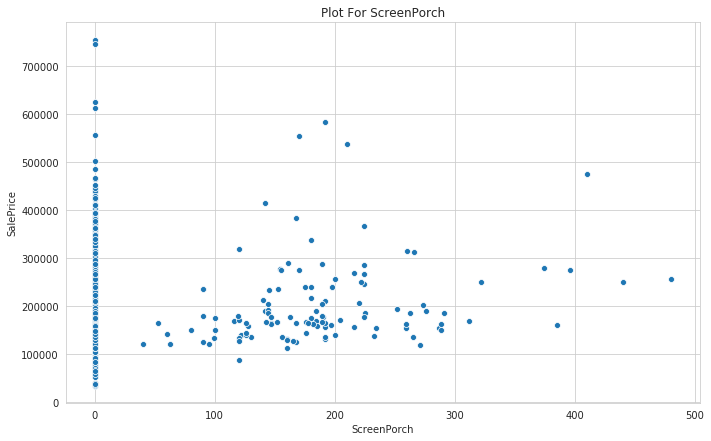

In [24]:
figures_per_time = 2
count = 0 

for cont_feature in cont_cols:
    try:
        plt.figure(count//figures_per_time,figsize=(25,7))
        plt.subplot(1,figures_per_time,np.mod(count,2)+1)
        sns.scatterplot(x=cont_feature,y=Target,data=df_data)
        plt.title('Plot For {}'.format(cont_feature))
        count+=1
    except:
        pass

# Outlier Check

In [25]:
def outlier_Value(datacolumn):
    
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    
    return lower_range,upper_range

Feature is  LotFrontage 

IQR Lower_Range is ---  31.5   IQR Upper_Range is ----  107.5   Feature_Name is --- LotFrontage 



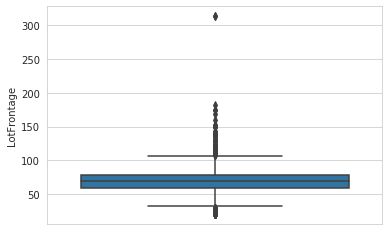

Feature is  LotArea 

IQR Lower_Range is ---  1481.5   IQR Upper_Range is ----  17673.5   Feature_Name is --- LotArea 



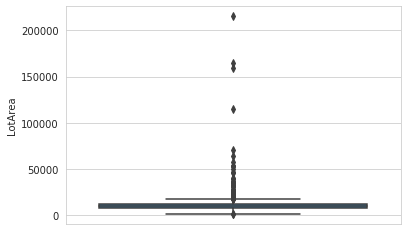

Feature is  MasVnrArea 

IQR Lower_Range is ---  -246.375   IQR Upper_Range is ----  410.625   Feature_Name is --- MasVnrArea 



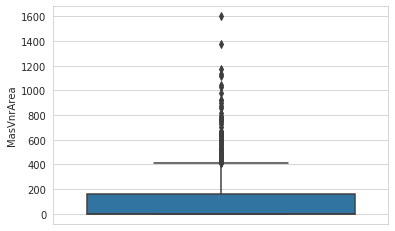

Feature is  BsmtFinSF1 

IQR Lower_Range is ---  -1068.375   IQR Upper_Range is ----  1780.625   Feature_Name is --- BsmtFinSF1 



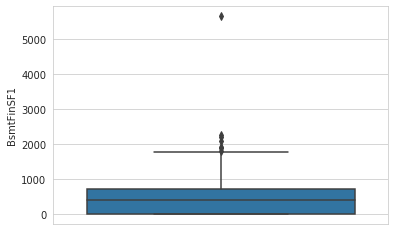

Feature is  BsmtFinSF2 

IQR Lower_Range is ---  0.0   IQR Upper_Range is ----  0.0   Feature_Name is --- BsmtFinSF2 



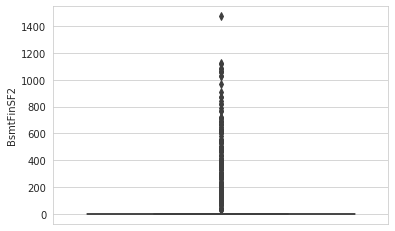

Feature is  BsmtUnfSF 

IQR Lower_Range is ---  -654.5   IQR Upper_Range is ----  1685.5   Feature_Name is --- BsmtUnfSF 



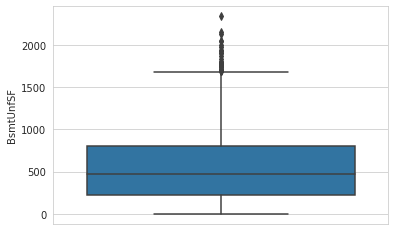

Feature is  TotalBsmtSF 

IQR Lower_Range is ---  42.0   IQR Upper_Range is ----  2052.0   Feature_Name is --- TotalBsmtSF 



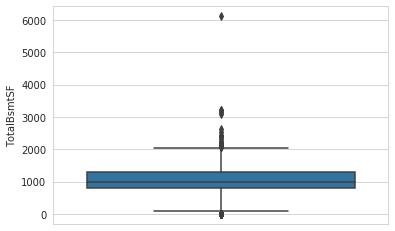

Feature is  1stFlrSF 

IQR Lower_Range is ---  118.125   IQR Upper_Range is ----  2155.125   Feature_Name is --- 1stFlrSF 



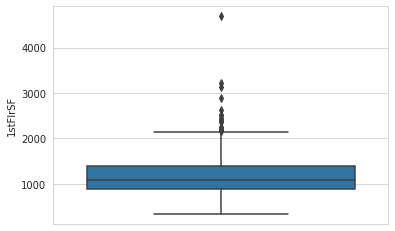

Feature is  2ndFlrSF 

IQR Lower_Range is ---  -1092.0   IQR Upper_Range is ----  1820.0   Feature_Name is --- 2ndFlrSF 



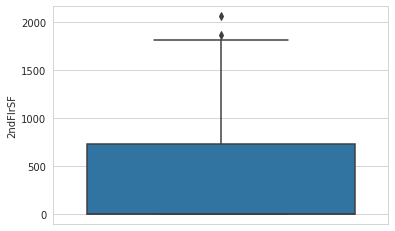

Feature is  GrLivArea 

IQR Lower_Range is ---  158.625   IQR Upper_Range is ----  2747.625   Feature_Name is --- GrLivArea 



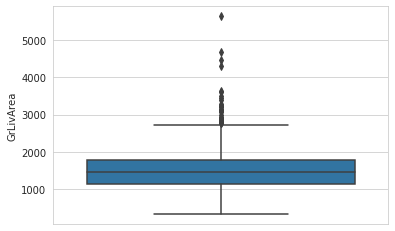

Feature is  GarageArea 

IQR Lower_Range is ---  -27.75   IQR Upper_Range is ----  938.25   Feature_Name is --- GarageArea 



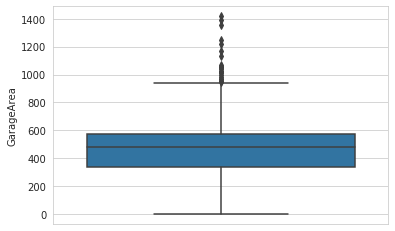

Feature is  WoodDeckSF 

IQR Lower_Range is ---  -252.0   IQR Upper_Range is ----  420.0   Feature_Name is --- WoodDeckSF 



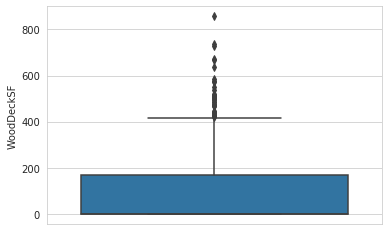

Feature is  OpenPorchSF 

IQR Lower_Range is ---  -102.0   IQR Upper_Range is ----  170.0   Feature_Name is --- OpenPorchSF 



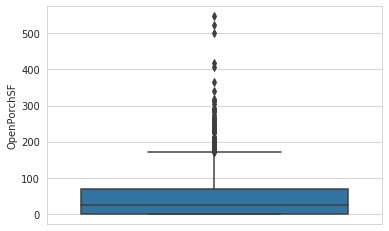

Feature is  EnclosedPorch 

IQR Lower_Range is ---  0.0   IQR Upper_Range is ----  0.0   Feature_Name is --- EnclosedPorch 



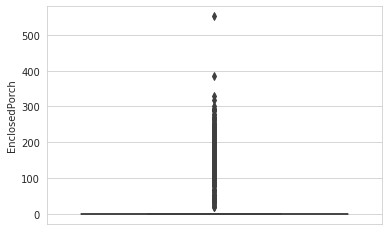

Feature is  ScreenPorch 

IQR Lower_Range is ---  0.0   IQR Upper_Range is ----  0.0   Feature_Name is --- ScreenPorch 



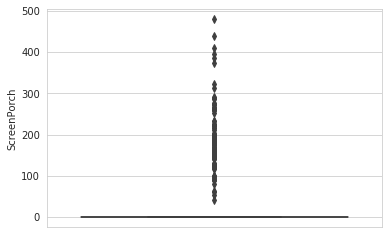

In [26]:
# Outliers
for feature in cont_cols:
    print("Feature is ", feature, "\n")
    Lower_Range, Upper_Range = outlier_Value(df_data[feature])
    print("IQR Lower_Range is --- ",Lower_Range,"  IQR Upper_Range is ---- ",Upper_Range,"  Feature_Name is ---",feature,"\n")
    sns.boxplot(y=df_data[feature])
    plt.show()

In [27]:
# Impute Outliers
for feature in cont_cols:
    Lower_Range, Upper_Range = outlier_Value(df_data[feature])
    if Lower_Range == 0.0 and Upper_Range == 0.0:
        print(feature)
        pass
    else:
        df_data.loc[df_data[feature]>Upper_Range, feature] = Upper_Range

BsmtFinSF2
EnclosedPorch
ScreenPorch


Feature is  LotFrontage 

IQR Lower_Range is ---  31.5   IQR Upper_Range is ----  107.5   Feature_Name is --- LotFrontage 



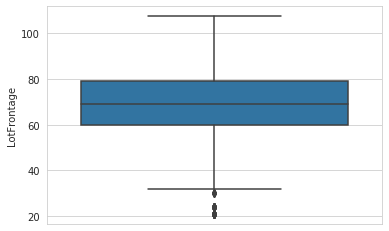

Feature is  LotArea 

IQR Lower_Range is ---  1481.5   IQR Upper_Range is ----  17673.5   Feature_Name is --- LotArea 



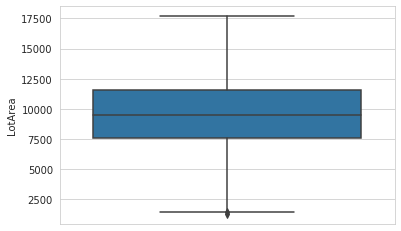

Feature is  MasVnrArea 

IQR Lower_Range is ---  -246.375   IQR Upper_Range is ----  410.625   Feature_Name is --- MasVnrArea 



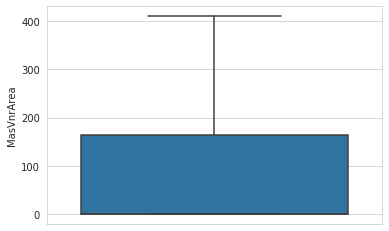

Feature is  BsmtFinSF1 

IQR Lower_Range is ---  -1068.375   IQR Upper_Range is ----  1780.625   Feature_Name is --- BsmtFinSF1 



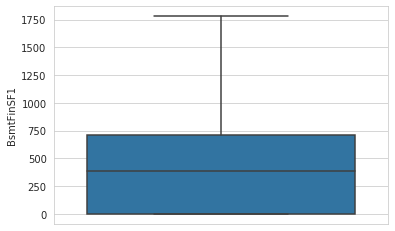

Feature is  BsmtFinSF2 

IQR Lower_Range is ---  0.0   IQR Upper_Range is ----  0.0   Feature_Name is --- BsmtFinSF2 



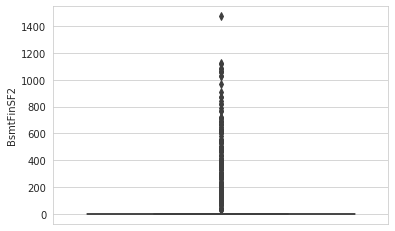

Feature is  BsmtUnfSF 

IQR Lower_Range is ---  -654.5   IQR Upper_Range is ----  1685.5   Feature_Name is --- BsmtUnfSF 



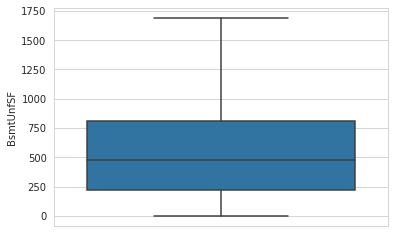

Feature is  TotalBsmtSF 

IQR Lower_Range is ---  42.0   IQR Upper_Range is ----  2052.0   Feature_Name is --- TotalBsmtSF 



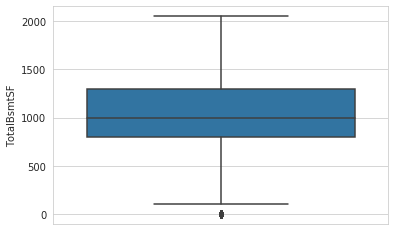

Feature is  1stFlrSF 

IQR Lower_Range is ---  118.125   IQR Upper_Range is ----  2155.125   Feature_Name is --- 1stFlrSF 



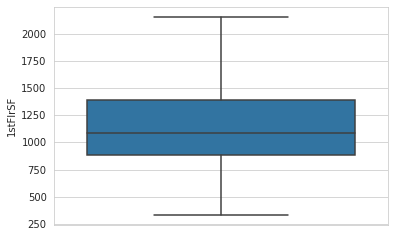

Feature is  2ndFlrSF 

IQR Lower_Range is ---  -1092.0   IQR Upper_Range is ----  1820.0   Feature_Name is --- 2ndFlrSF 



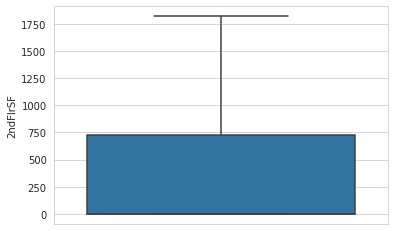

Feature is  GrLivArea 

IQR Lower_Range is ---  158.625   IQR Upper_Range is ----  2747.625   Feature_Name is --- GrLivArea 



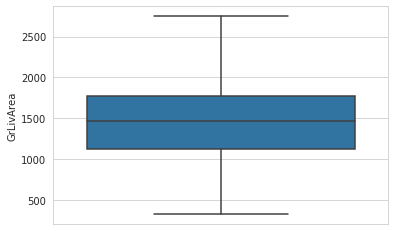

Feature is  GarageArea 

IQR Lower_Range is ---  -27.75   IQR Upper_Range is ----  938.25   Feature_Name is --- GarageArea 



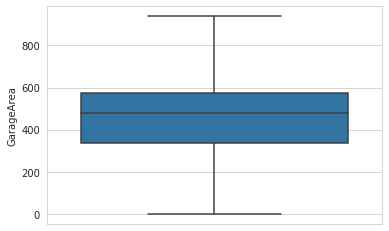

Feature is  WoodDeckSF 

IQR Lower_Range is ---  -252.0   IQR Upper_Range is ----  420.0   Feature_Name is --- WoodDeckSF 



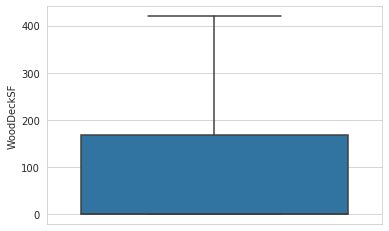

Feature is  OpenPorchSF 

IQR Lower_Range is ---  -102.0   IQR Upper_Range is ----  170.0   Feature_Name is --- OpenPorchSF 



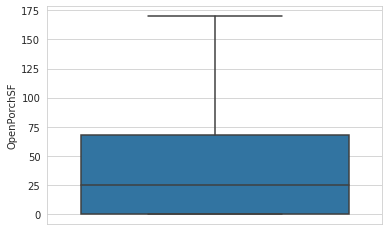

Feature is  EnclosedPorch 

IQR Lower_Range is ---  0.0   IQR Upper_Range is ----  0.0   Feature_Name is --- EnclosedPorch 



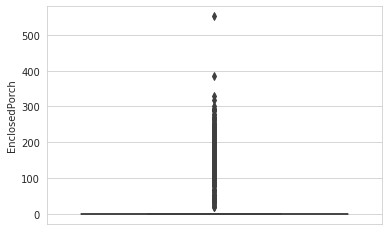

Feature is  ScreenPorch 

IQR Lower_Range is ---  0.0   IQR Upper_Range is ----  0.0   Feature_Name is --- ScreenPorch 



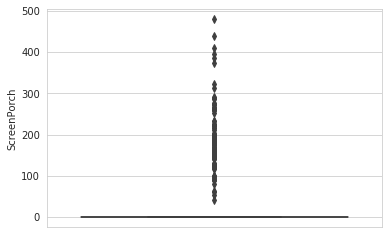

In [28]:
# Outliers
for feature in cont_cols:
    print("Feature is ", feature, "\n")
    Lower_Range, Upper_Range = outlier_Value(df_data[feature])
    print("IQR Lower_Range is --- ",Lower_Range,"  IQR Upper_Range is ---- ",Upper_Range,"  Feature_Name is ---",feature,"\n")
    sns.boxplot(y=df_data[feature])
    plt.show()

# EDA and Data Cleaning on Discrete columns 

In [29]:
df_data[discrete_cols].head()

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold
0,60,7,5,0,1,0,2,1,3,1,8,0,2,0,0,0,2
1,20,6,8,0,0,1,2,0,3,1,6,1,2,0,0,0,5
2,60,7,5,0,1,0,2,1,3,1,6,1,2,0,0,0,9
3,70,7,5,0,1,0,1,0,3,1,7,1,3,0,0,0,2
4,60,8,5,0,1,0,2,1,4,1,9,1,3,0,0,0,12


In [30]:
missing_features_discrete,_ =  Missing_constant_columns(df_data[discrete_cols])
missing_features_discrete

[]

# Filling Missing value of Discrete columns

In [31]:
def Missing_value_impute_disc(df,feature,threshold):
        if df[feature].isnull().sum()>1:
            Missing_value_per = float(np.round(df[feature].isnull().mean(), 4))
            if Missing_value_per <= threshold:
                df[feature].fillna(df[feature].mode()[0], inplace = True)
                print("filling missing value feature name is",feature,Missing_value_per)
            else:
                df.drop([feature],axis=1,inplace=True)
                print("Droping feature",feature,Missing_value_per,threshold)
        else:
            pass
        return df

In [32]:
for feature in df_data[discrete_cols].columns:
    df_data = Missing_value_impute_disc(df_data,feature,0.3)

# Visualization of Key Features on Discrete columns

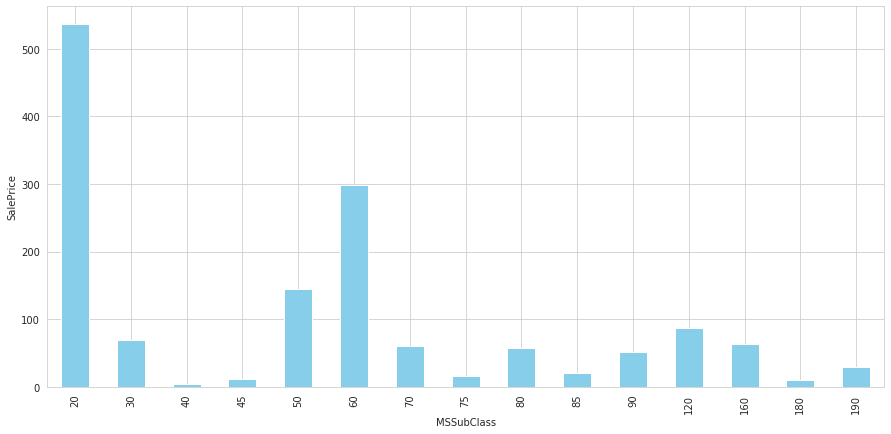

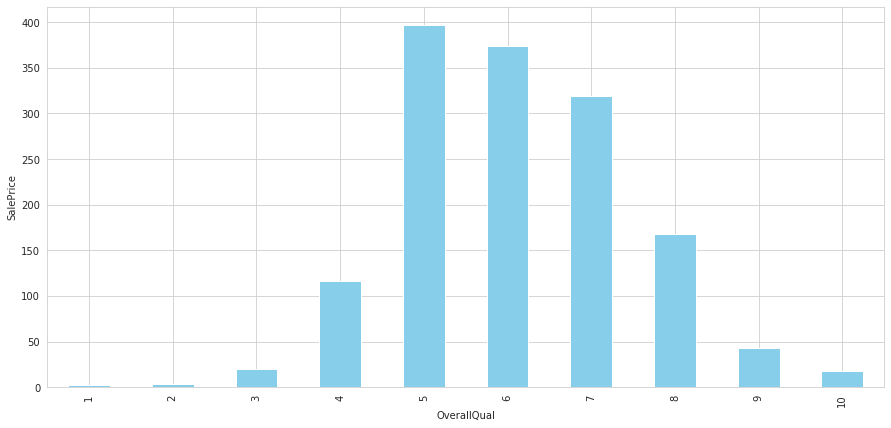

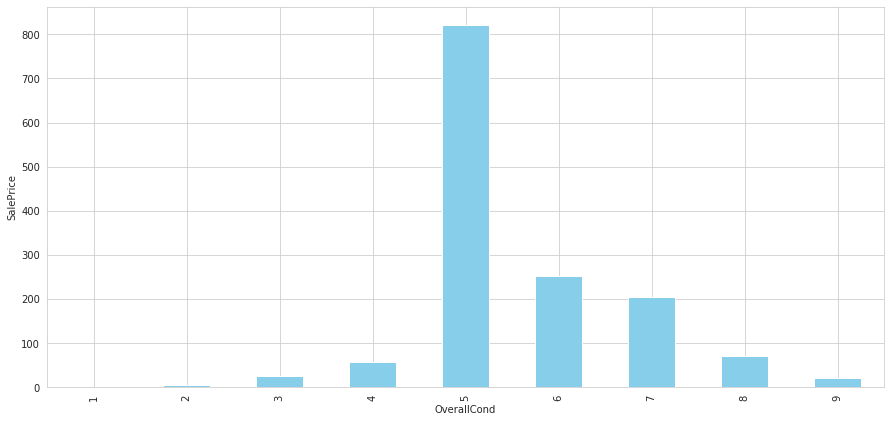

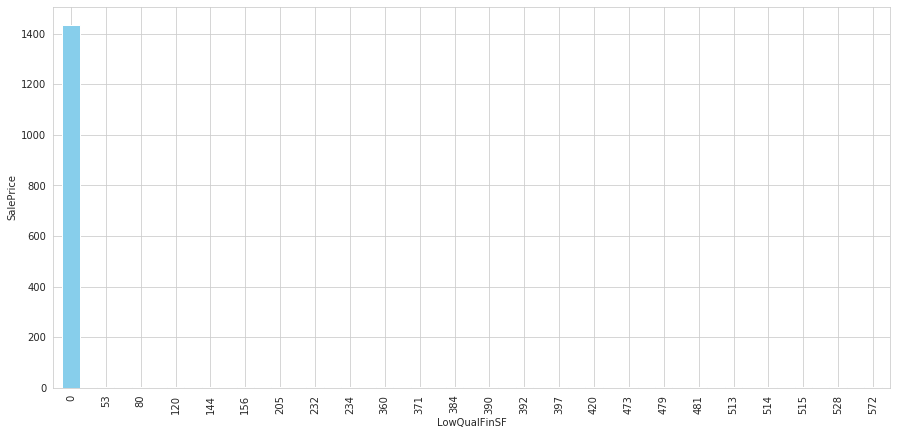

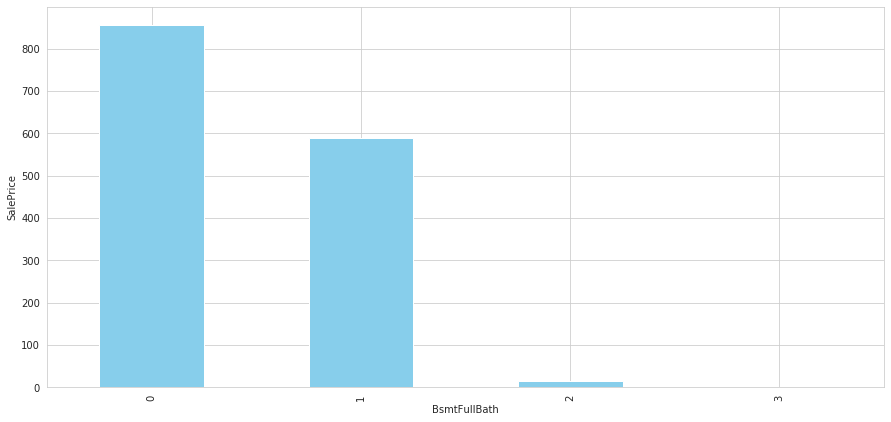

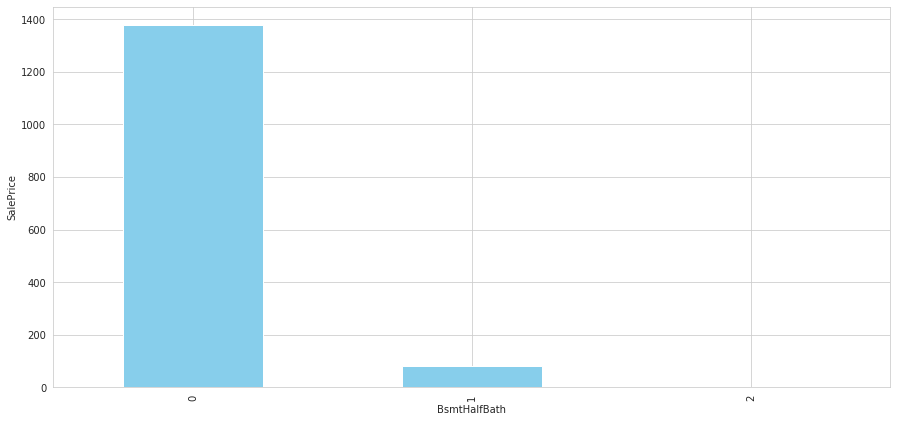

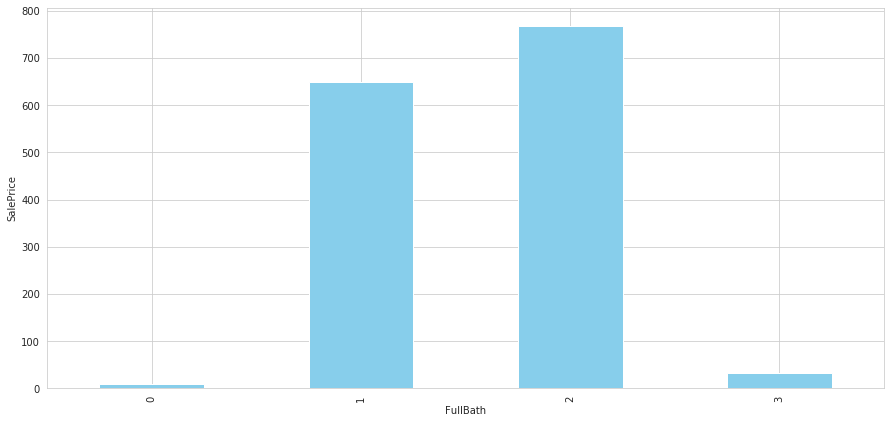

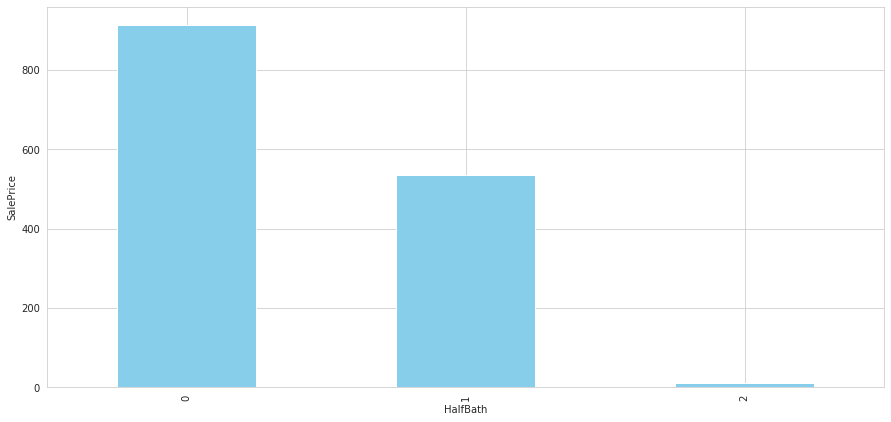

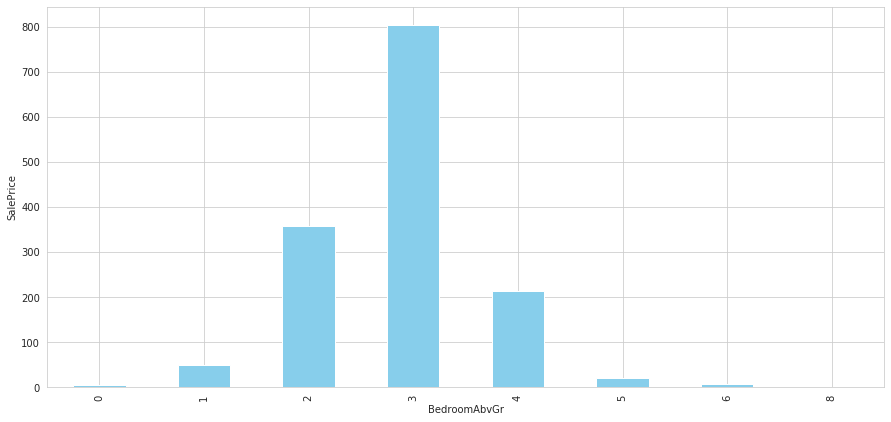

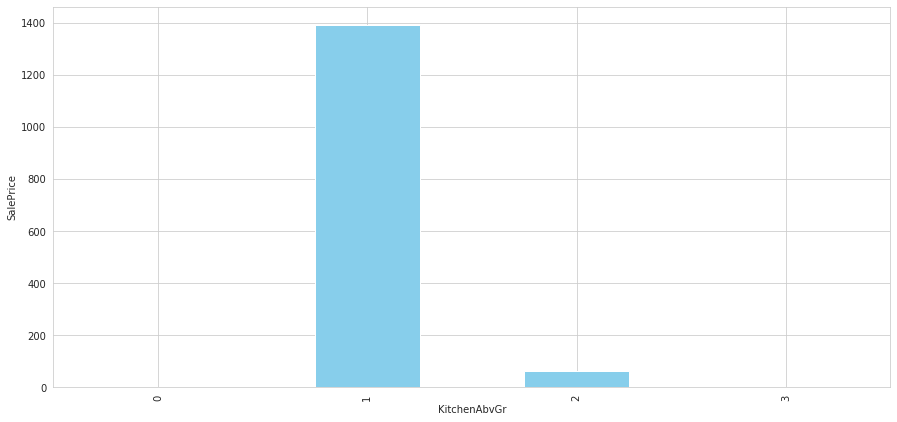

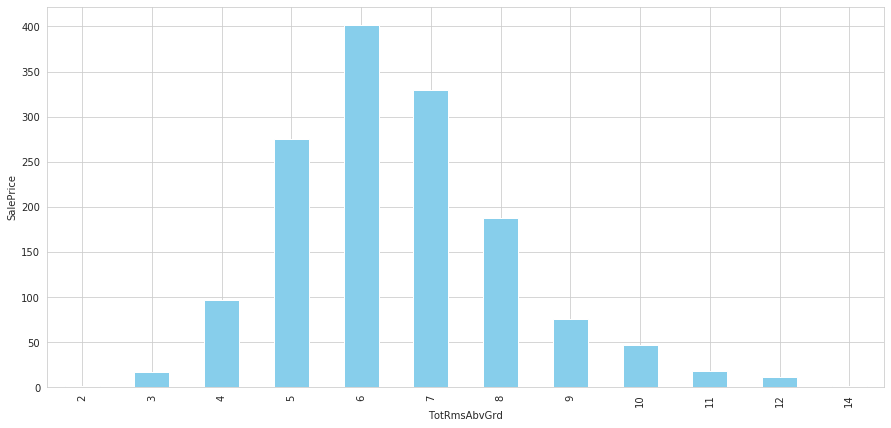

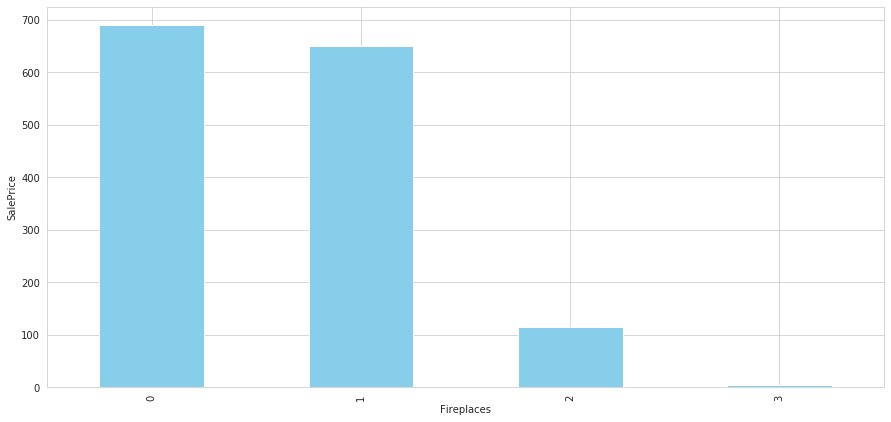

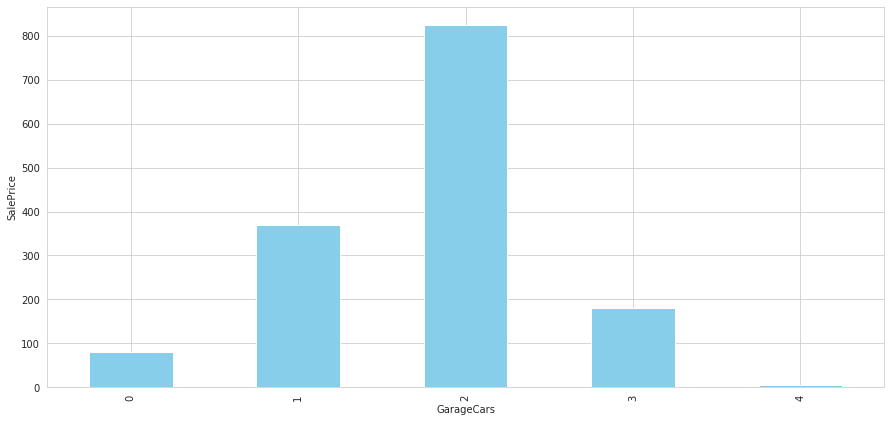

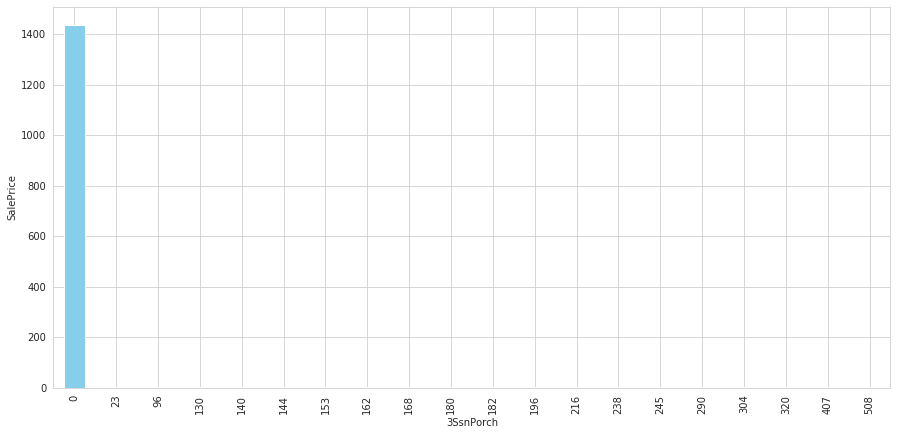

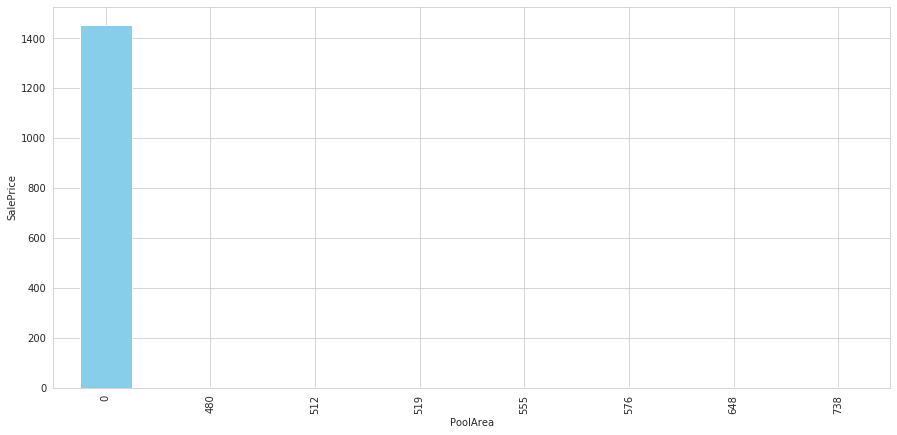

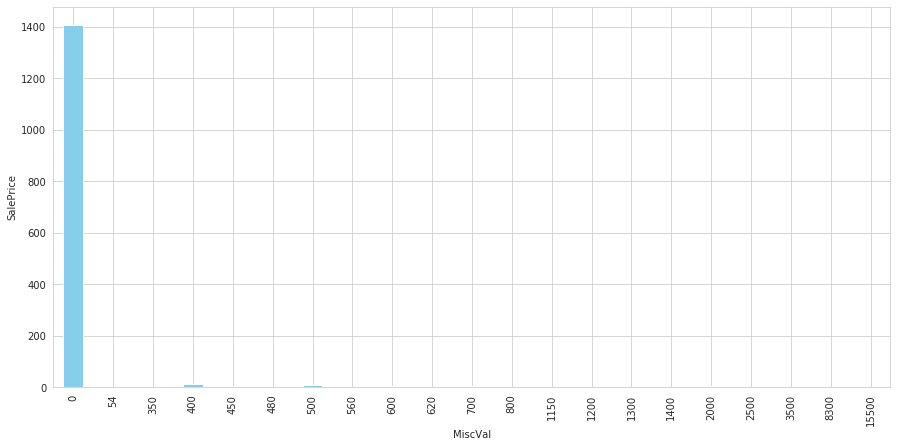

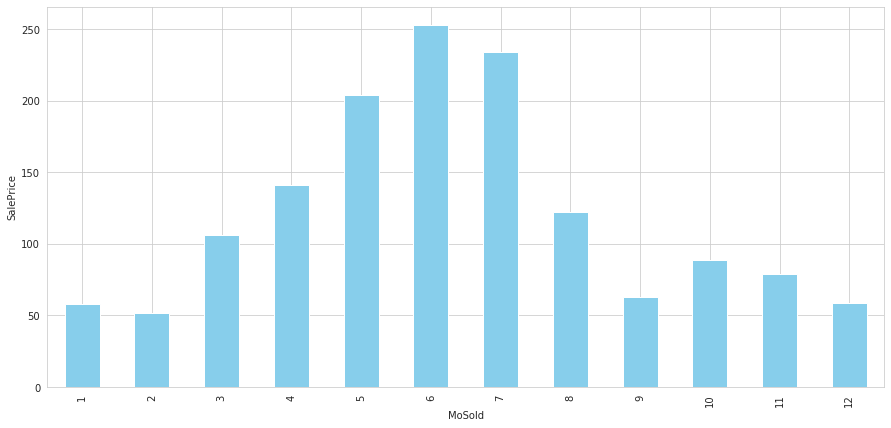

In [33]:
for feature in discrete_cols:
    try:
        fig, ax = plt.subplots(figsize=(15,7))
        data=df_data.copy()
        data.groupby(feature)[Target].count().plot.bar(ax=ax, cmap='viridis', color='skyblue')
        plt.xlabel(feature)
        plt.ylabel(Target)
        plt.show()
    except:
        pass

# Catorical columns

In [34]:
df_data[cat_cols].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [35]:
missing_features_cat,_ =  Missing_constant_columns(df_data[cat_cols])
missing_features_cat

['Alley has 0.9377% Missing values %',
 'MasVnrType has 0.0055% Missing values %',
 'BsmtQual has 0.0253% Missing values %',
 'BsmtCond has 0.0253% Missing values %',
 'BsmtExposure has 0.026% Missing values %',
 'BsmtFinType1 has 0.0253% Missing values %',
 'BsmtFinType2 has 0.026% Missing values %',
 'FireplaceQu has 0.4726% Missing values %',
 'GarageType has 0.0555% Missing values %',
 'GarageFinish has 0.0555% Missing values %',
 'GarageQual has 0.0555% Missing values %',
 'GarageCond has 0.0555% Missing values %',
 'PoolQC has 0.9952% Missing values %',
 'Fence has 0.8075% Missing values %',
 'MiscFeature has 0.963% Missing values %']

# Filling Missing value of Catorical columns

In [36]:
def Missing_value_impute_cat(df,feature,threshold):
        if df[feature].isnull().sum()>1:
            Missing_value_per = float(np.round(df[feature].isnull().mean(), 4))
            if Missing_value_per <= threshold:
                df[feature].fillna(df[feature].mode()[0], inplace = True)
                print("filling missing value feature name is",feature,Missing_value_per)
            else:
                df.drop([feature],axis=1,inplace=True)
                print("Droping feature",feature,Missing_value_per,threshold)
        else:
            pass
        return df

In [37]:
for feature in df_data[cat_cols].columns:
    df_data = Missing_value_impute_cat(df_data,feature,0.3)

Droping feature Alley 0.9377 0.3
filling missing value feature name is MasVnrType 0.0055
filling missing value feature name is BsmtQual 0.0253
filling missing value feature name is BsmtCond 0.0253
filling missing value feature name is BsmtExposure 0.026
filling missing value feature name is BsmtFinType1 0.0253
filling missing value feature name is BsmtFinType2 0.026
Droping feature FireplaceQu 0.4726 0.3
filling missing value feature name is GarageType 0.0555
filling missing value feature name is GarageFinish 0.0555
filling missing value feature name is GarageQual 0.0555
filling missing value feature name is GarageCond 0.0555
Droping feature PoolQC 0.9952 0.3
Droping feature Fence 0.8075 0.3
Droping feature MiscFeature 0.963 0.3


# Visualization of Key Features on Catorical columns

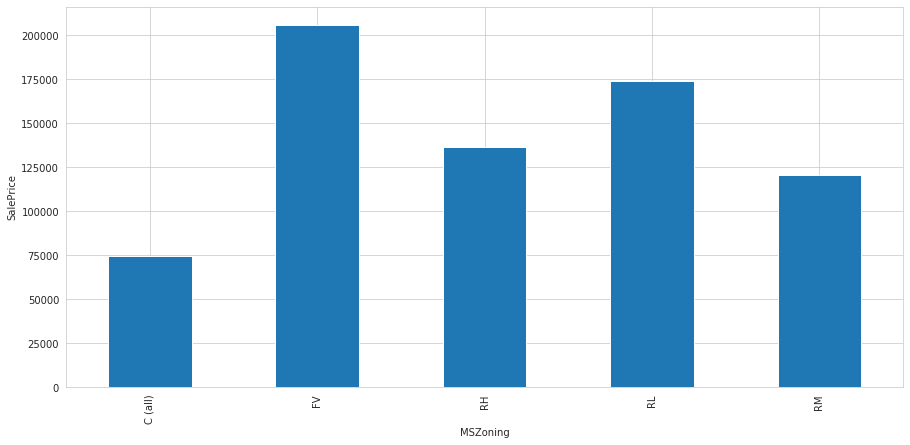

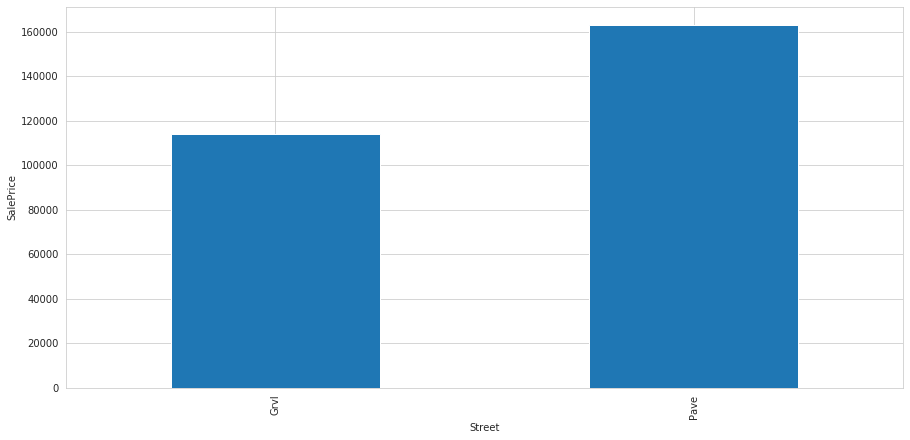

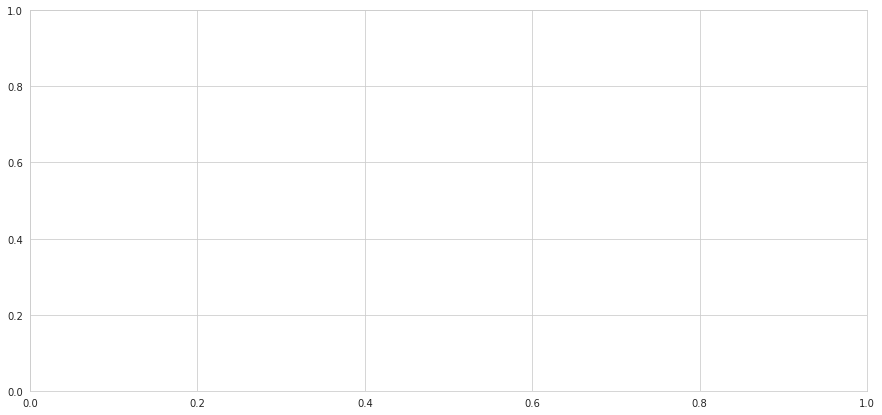

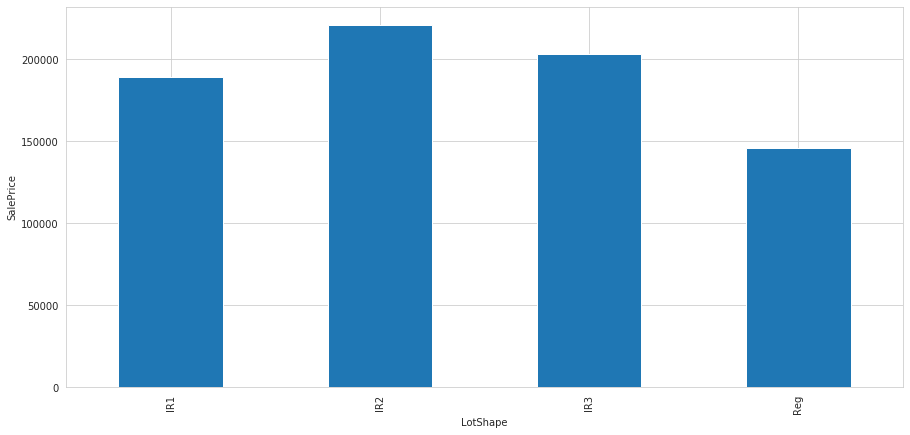

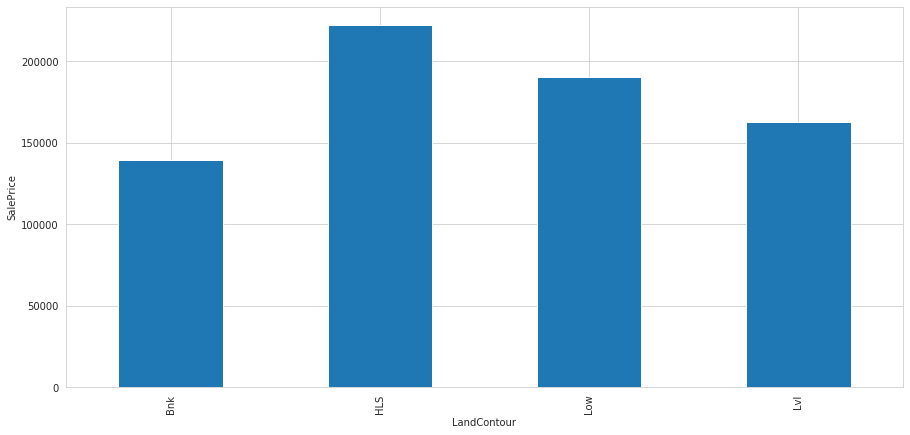

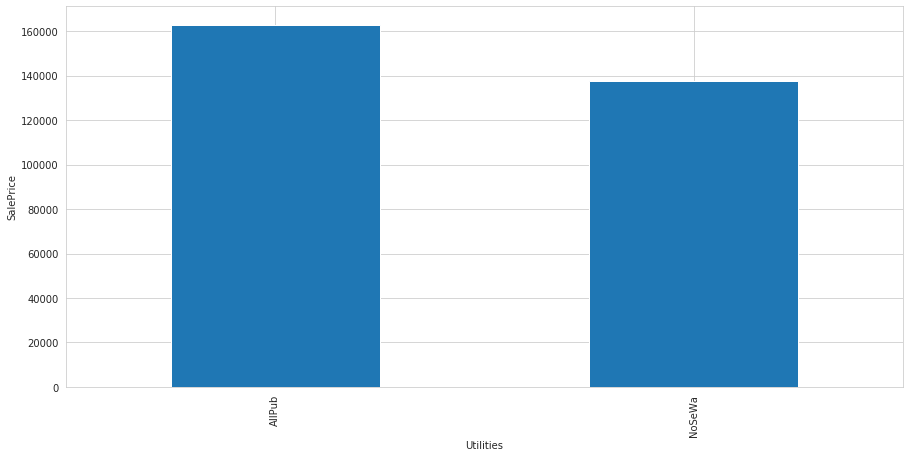

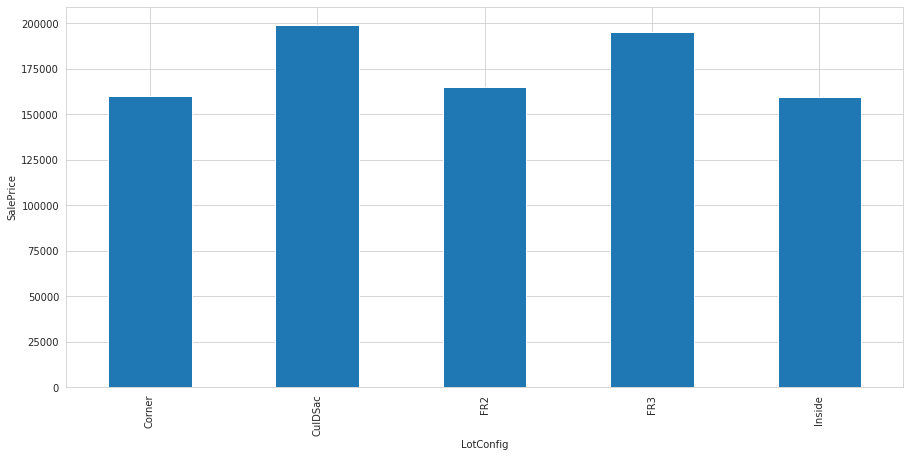

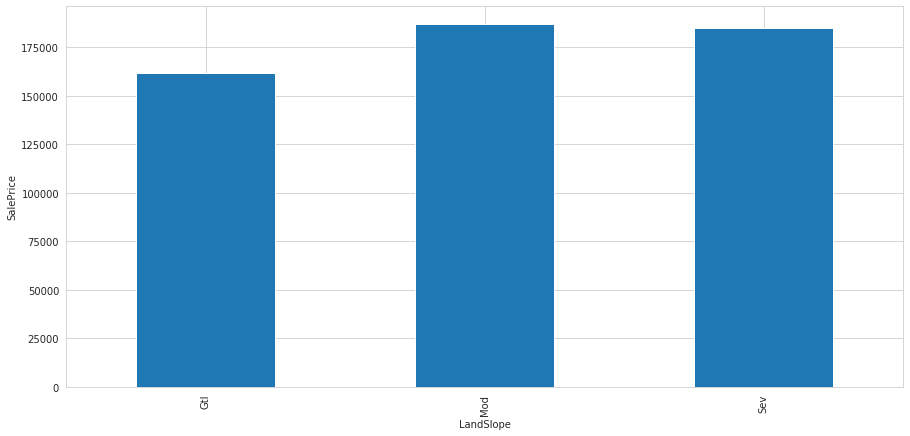

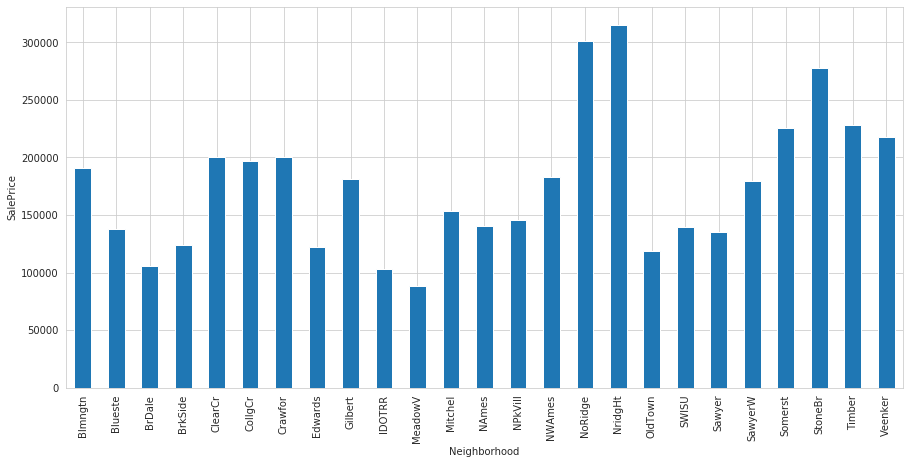

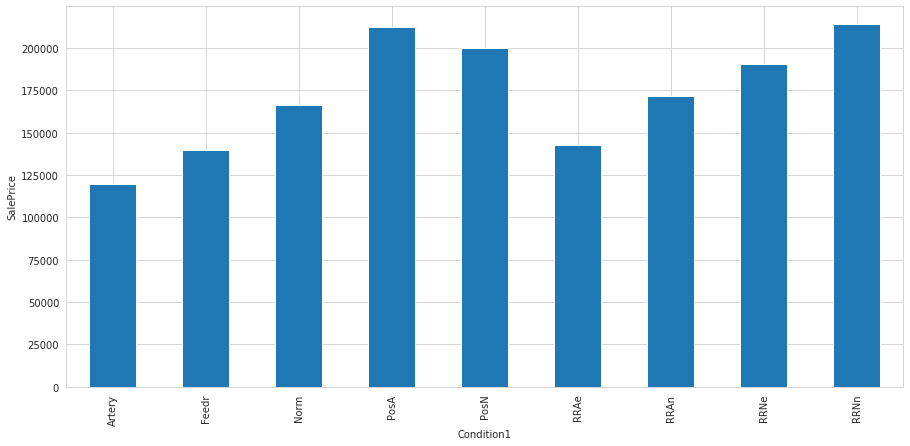

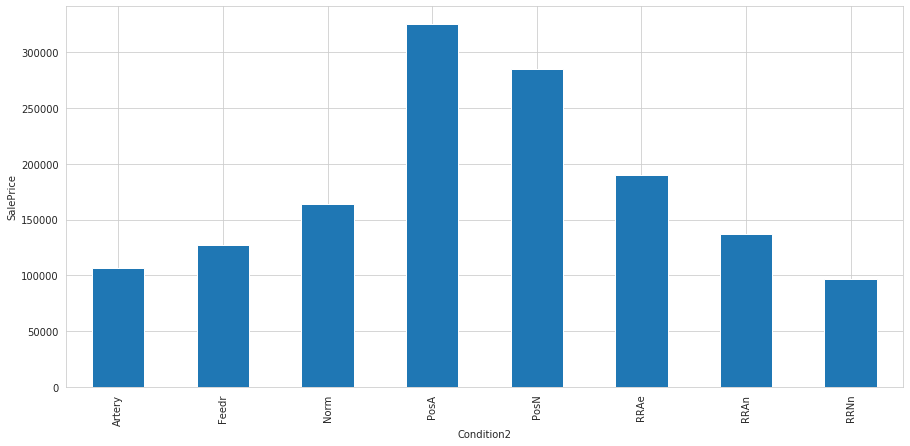

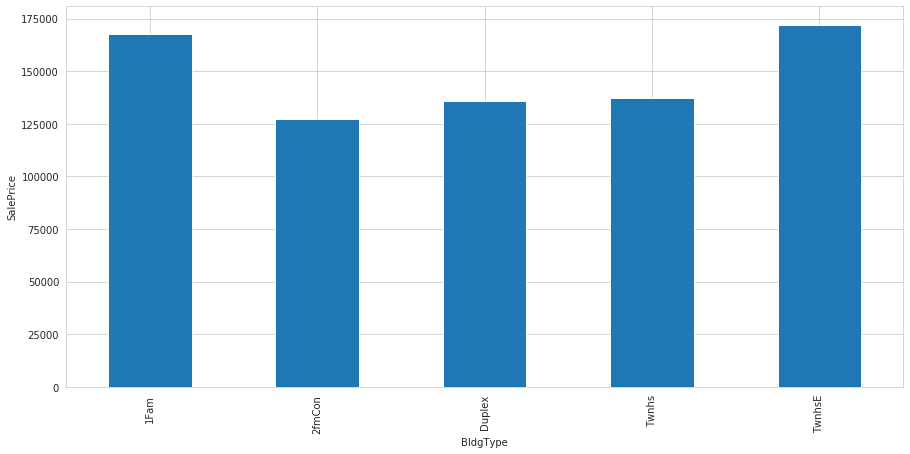

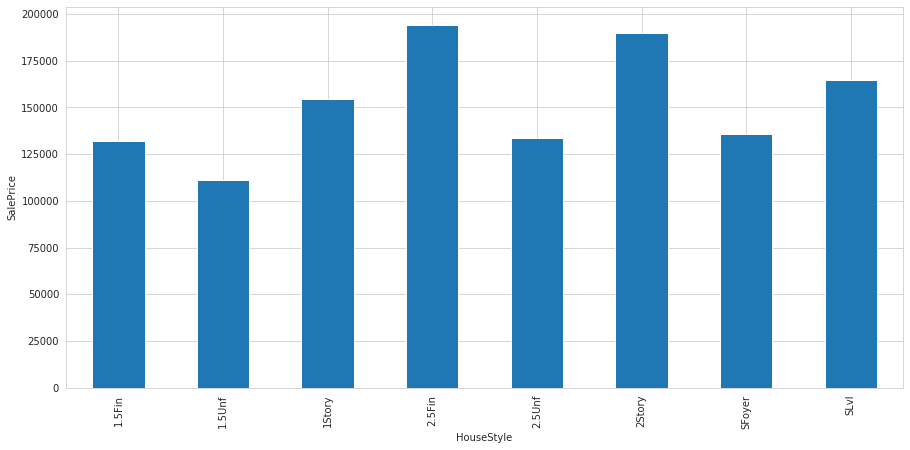

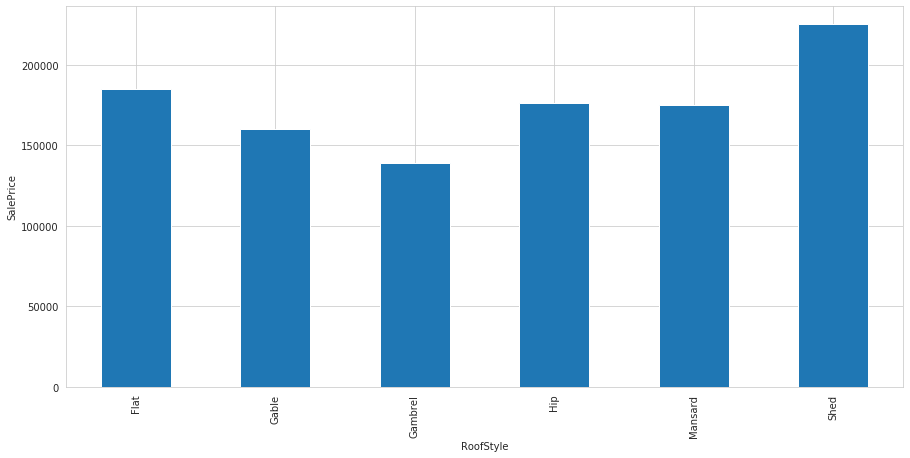

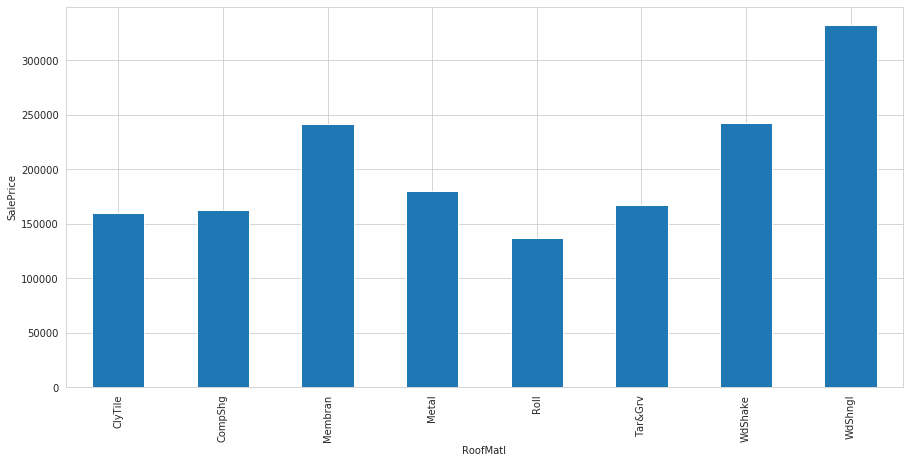

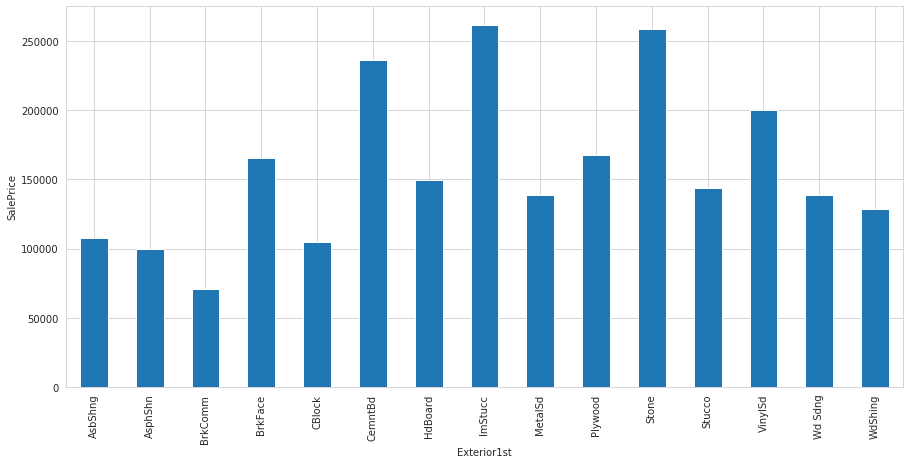

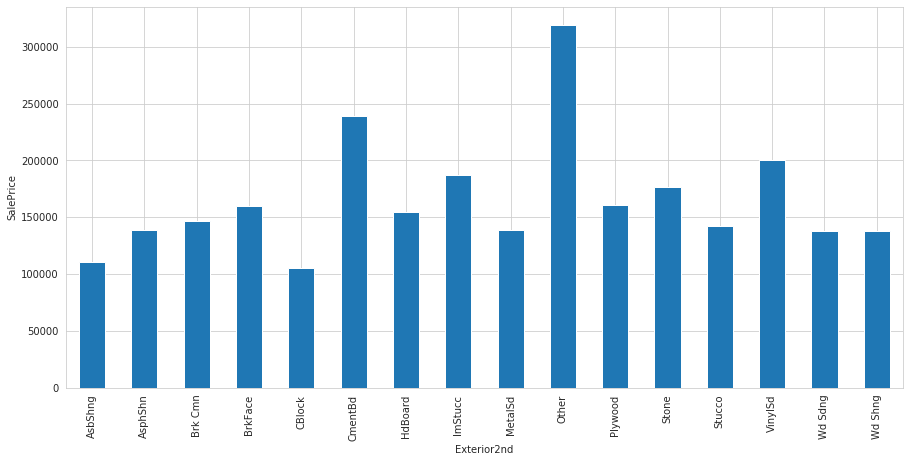

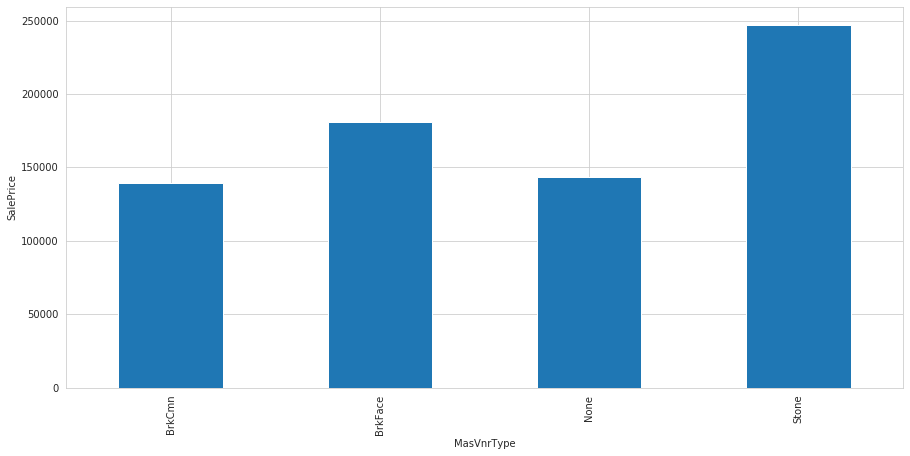

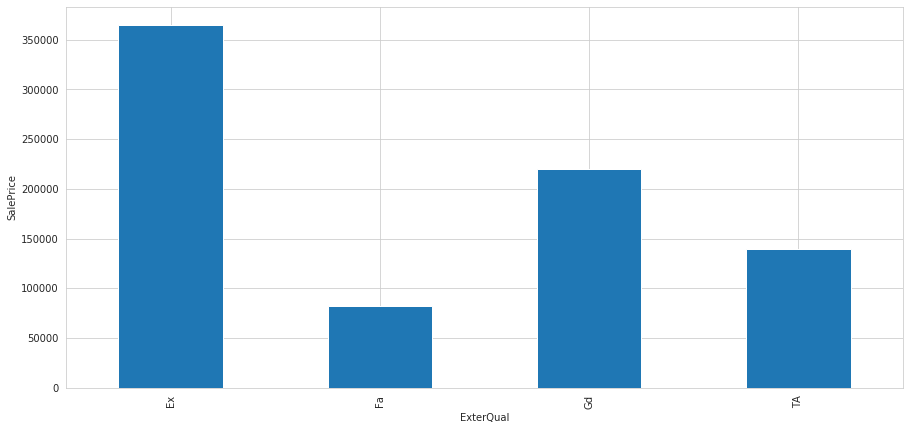

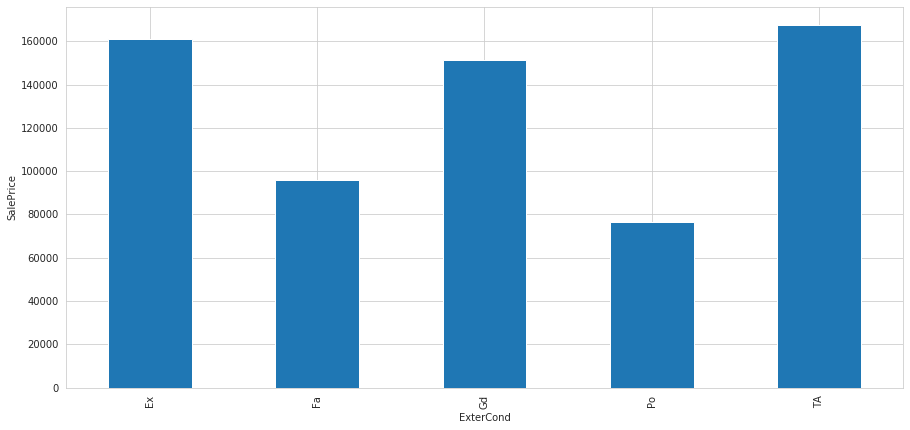

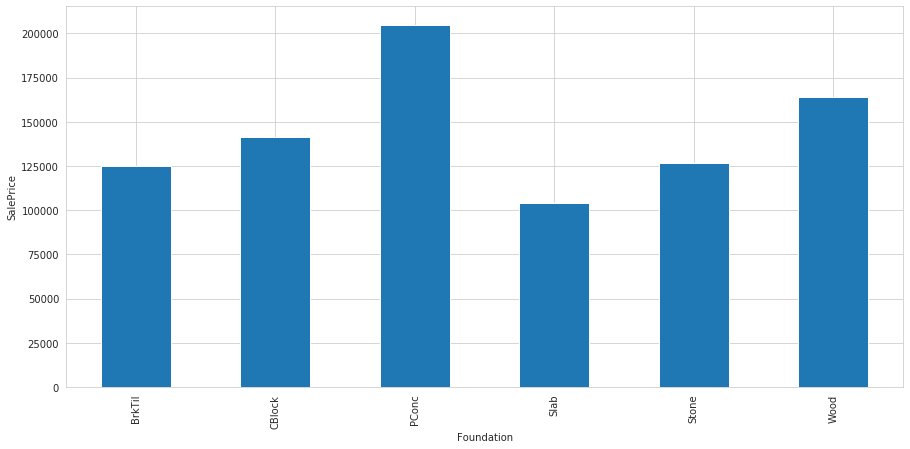

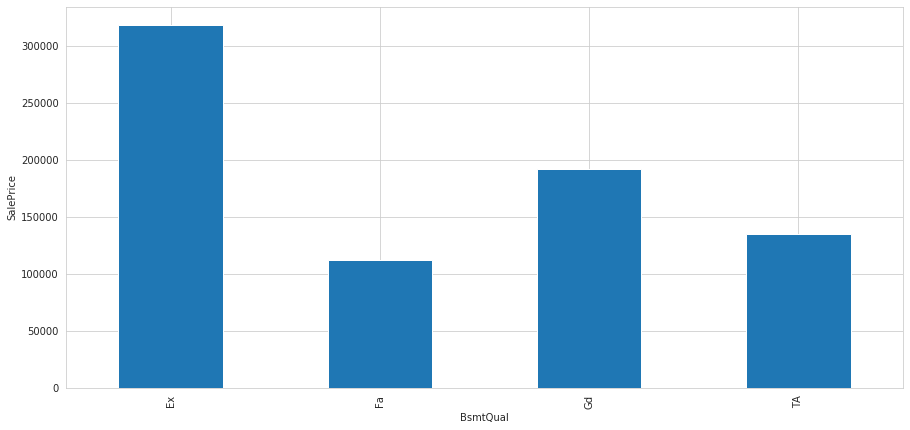

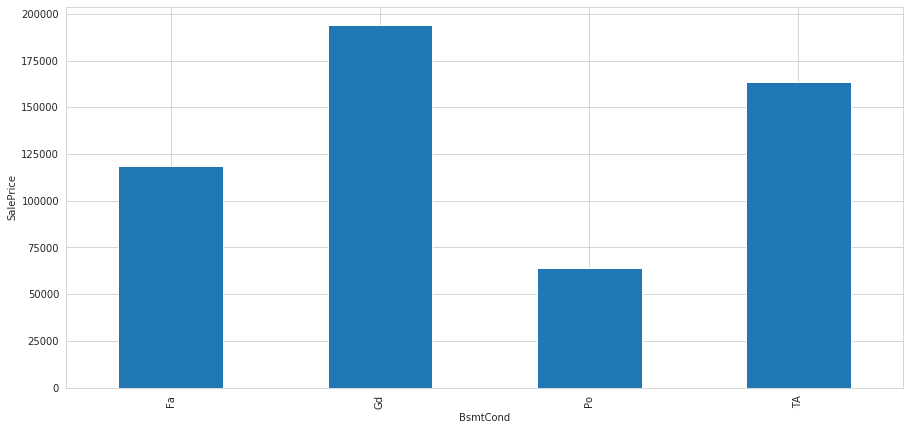

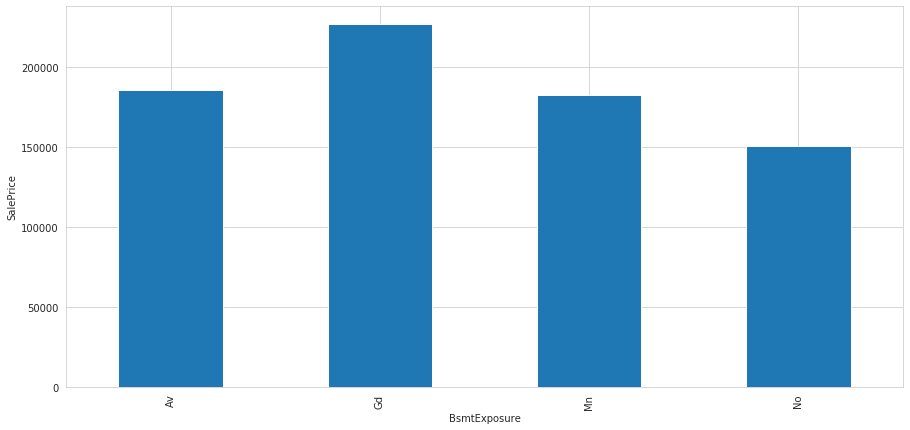

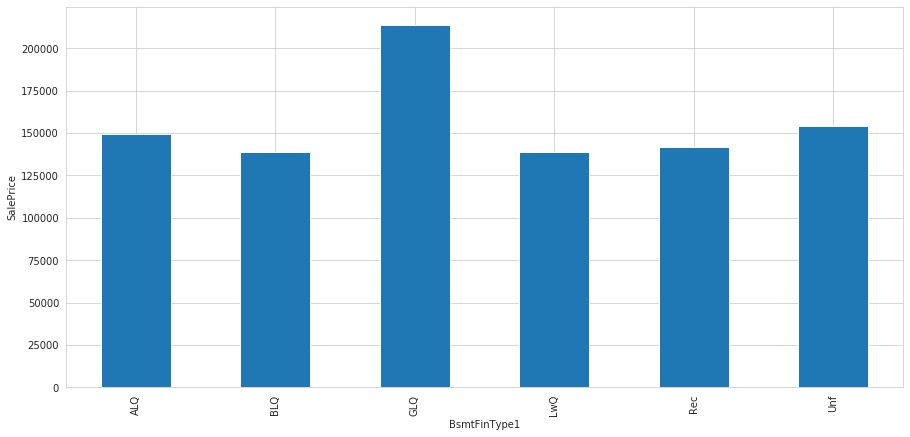

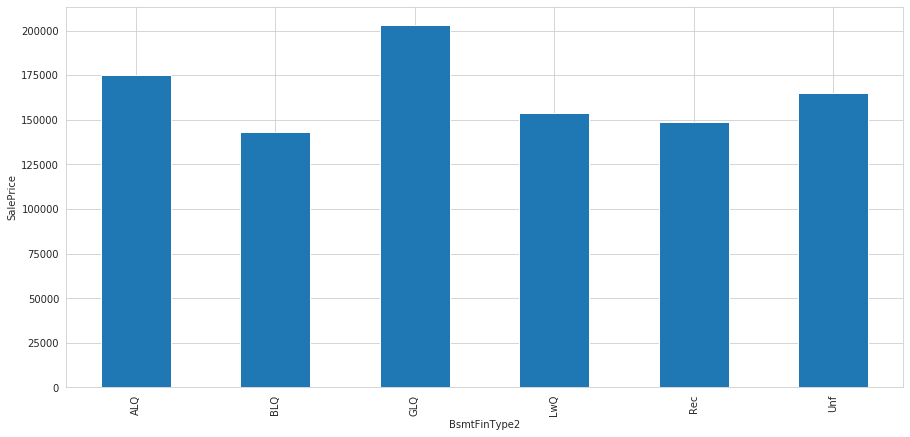

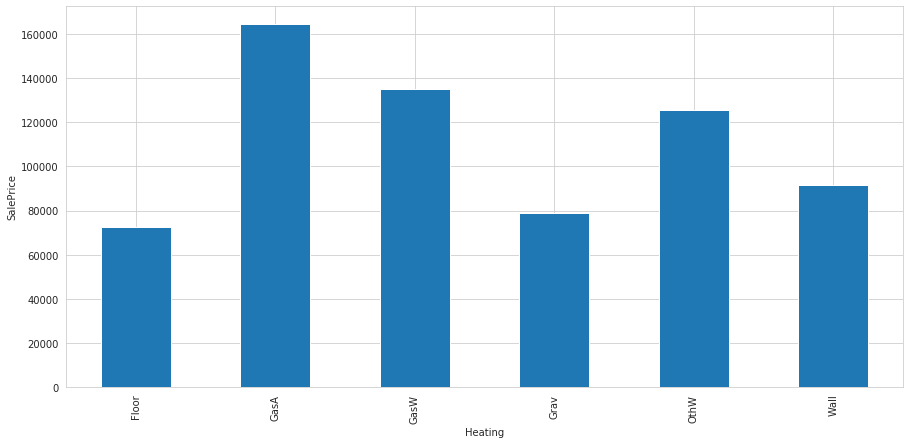

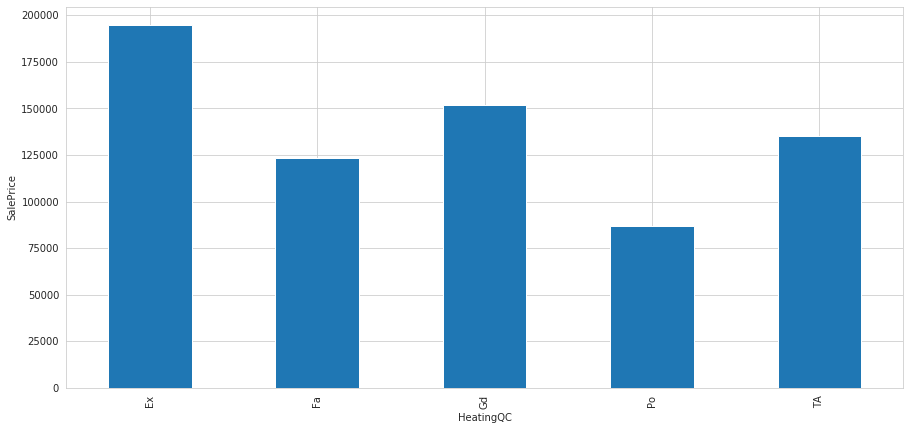

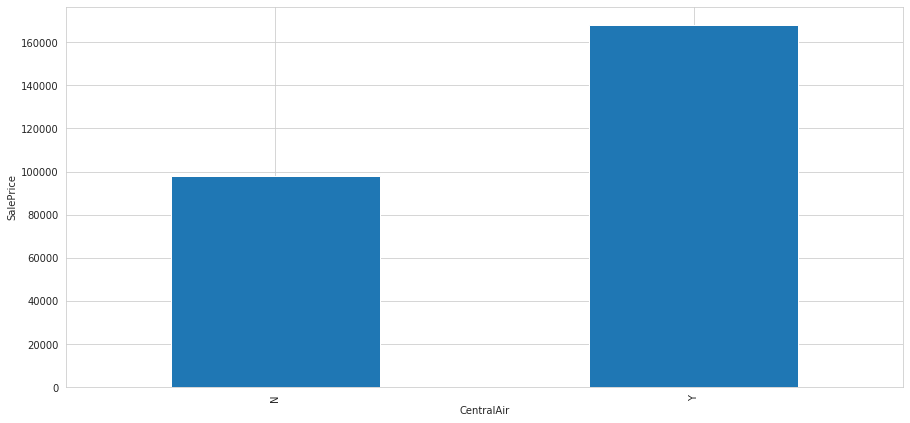

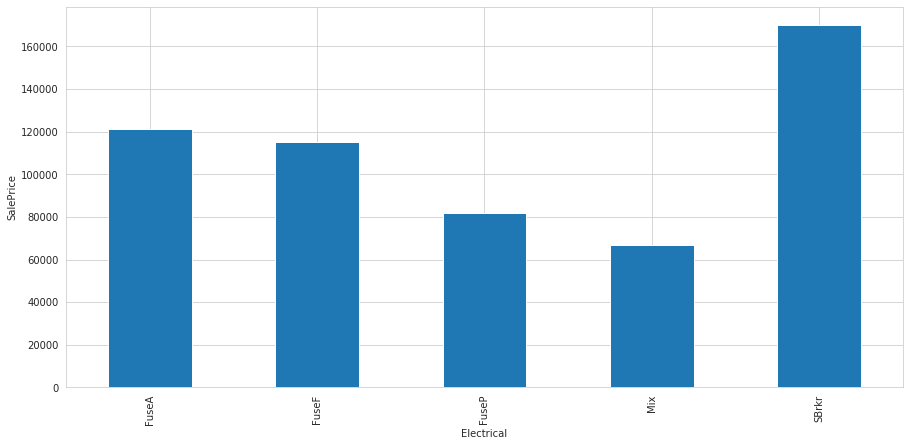

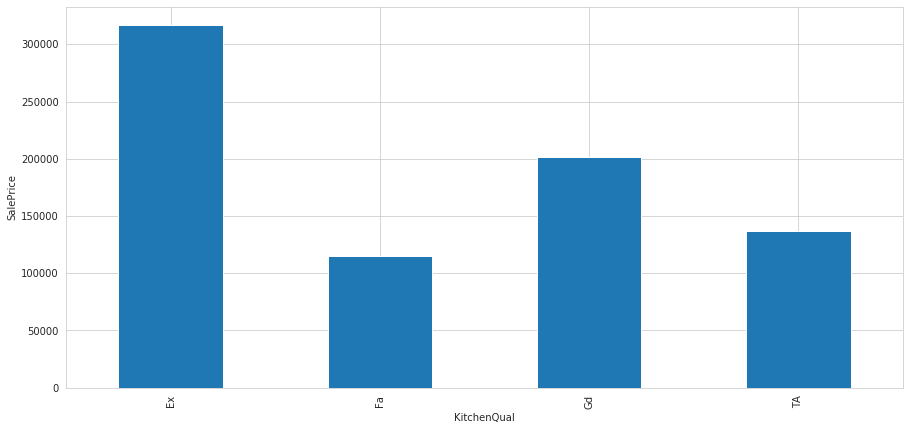

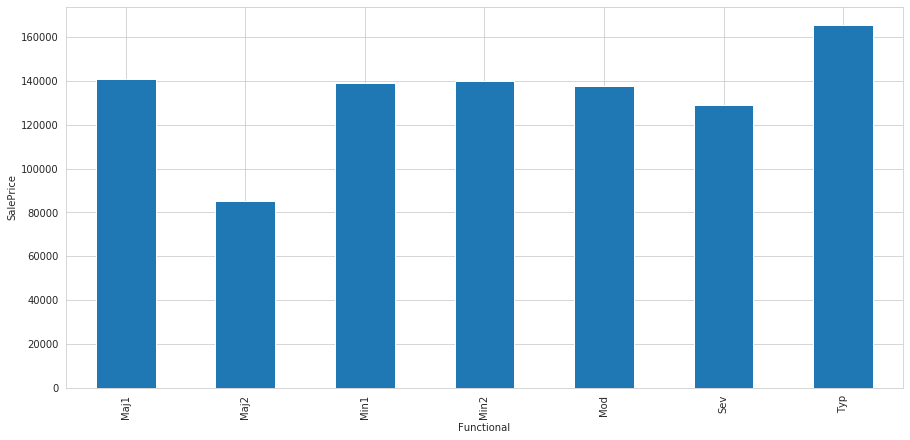

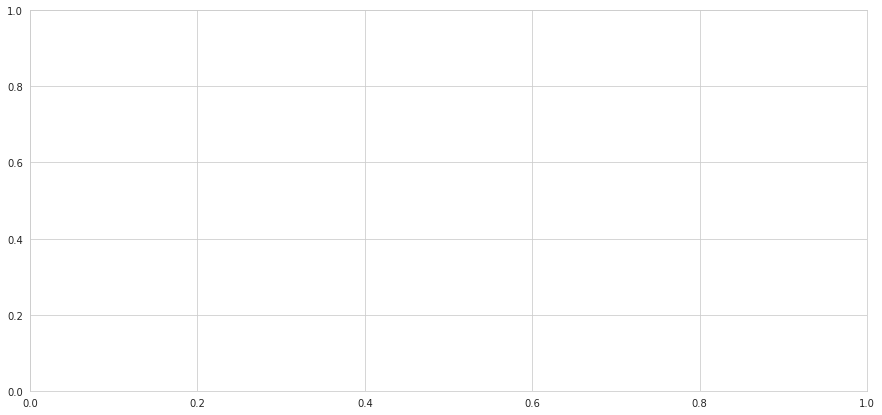

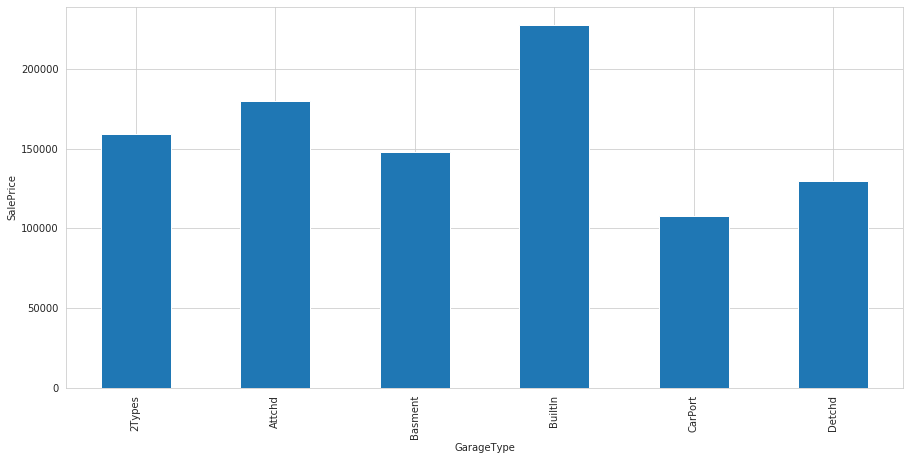

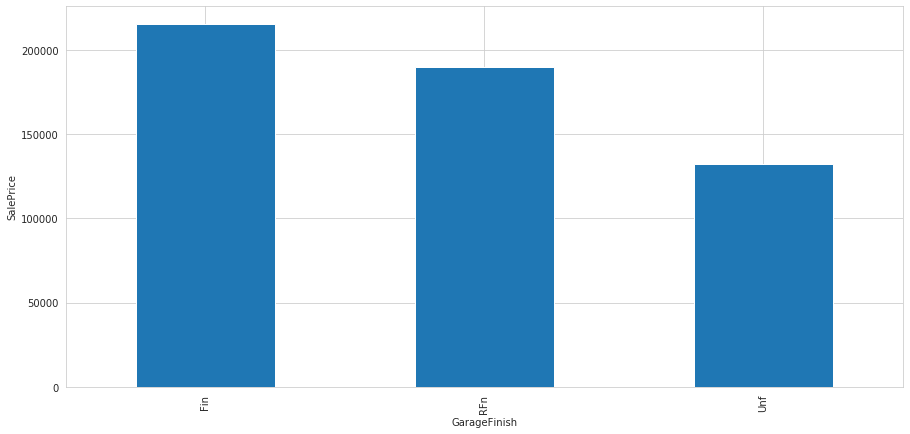

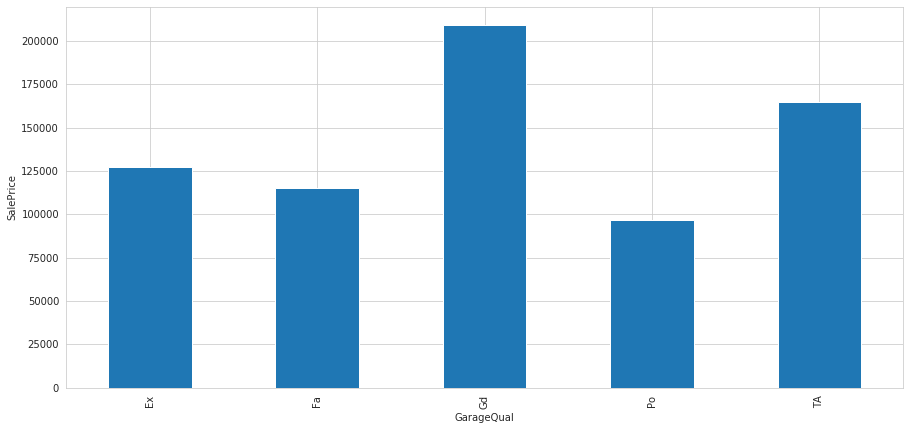

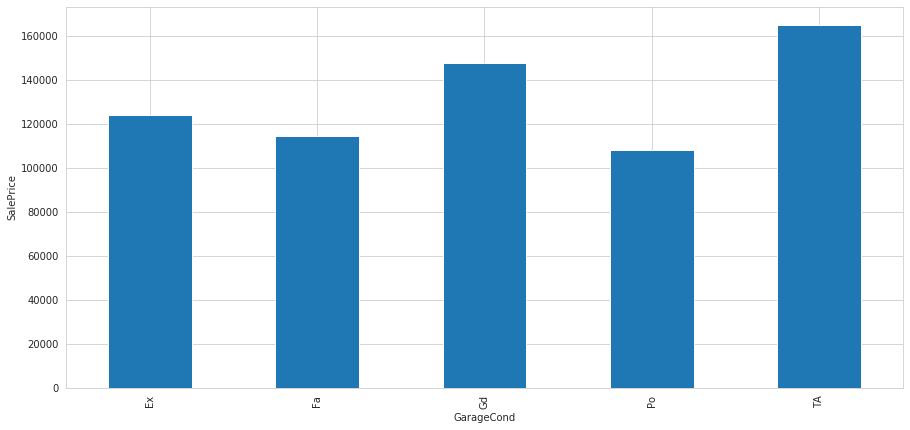

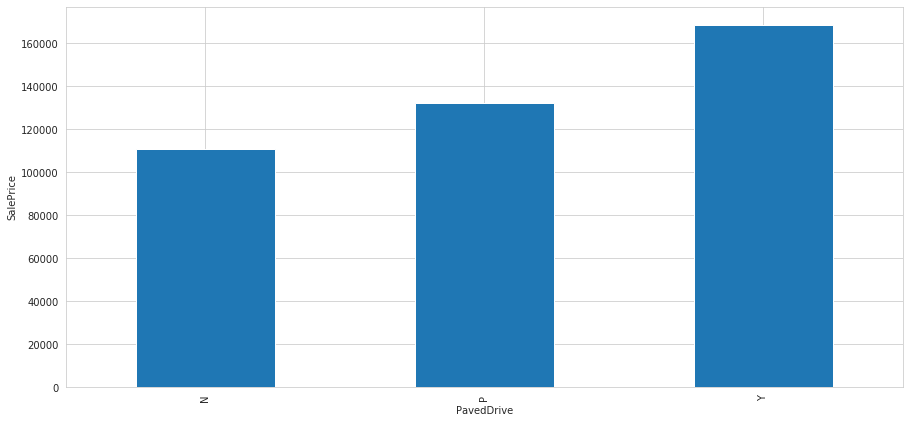

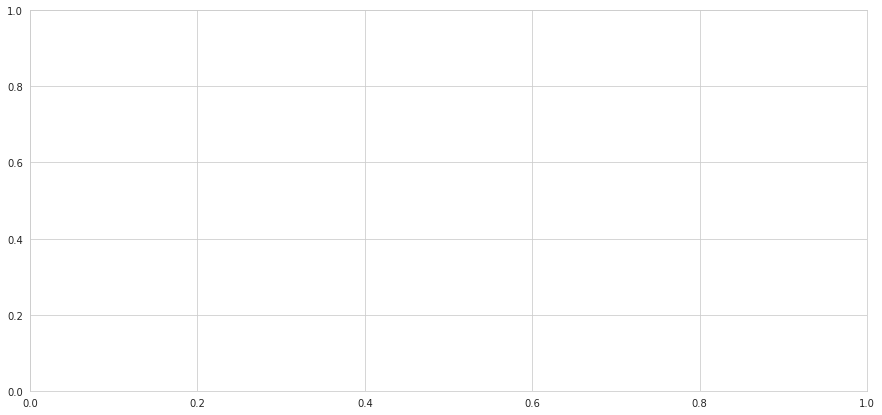

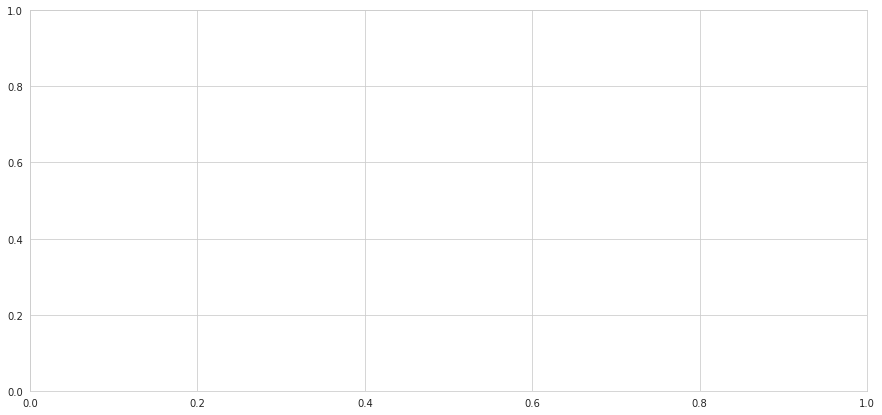

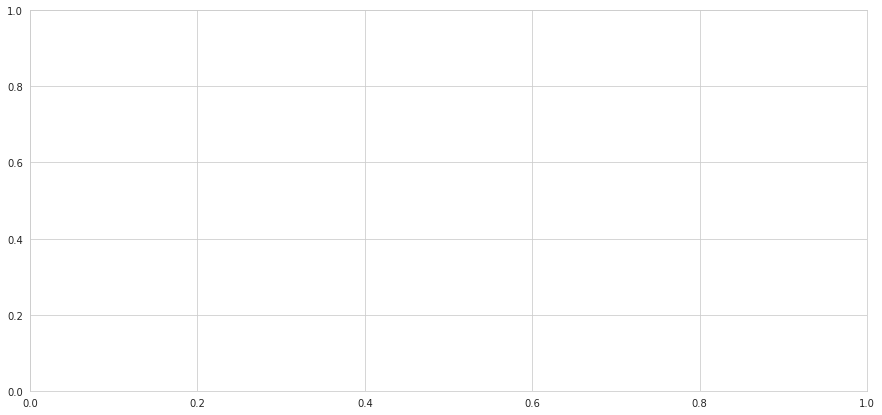

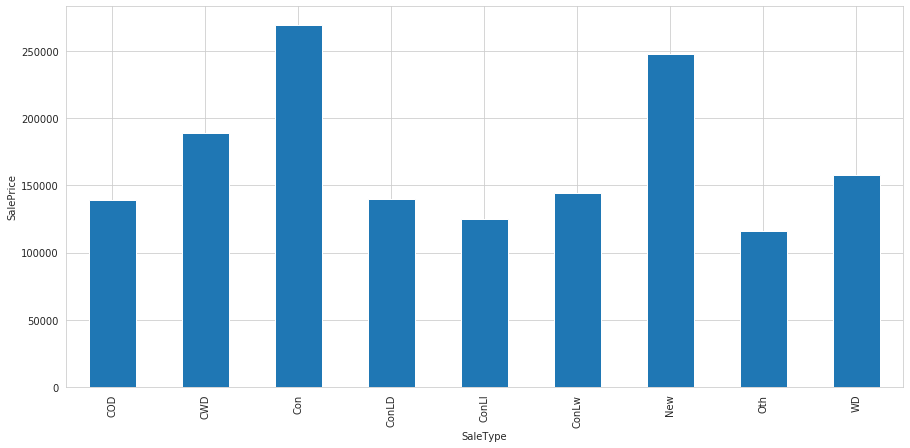

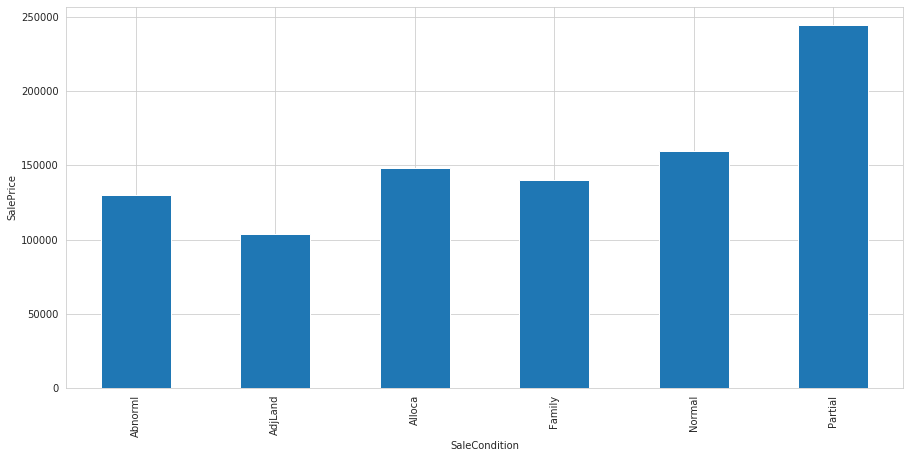

In [38]:
for feature in cat_cols:
    try:
        fig, ax = plt.subplots(figsize=(15,7))
        data=df_data.copy()
        data.groupby(feature)[Target].median().plot.bar()
        plt.xlabel(feature)
        plt.ylabel(Target)
        plt.show()
    except:
        pass

# Mean encoding for catogorical Variable 

In [39]:
def mean_encoding(df,feature,Target):
    try:
        Mean_encoded = df.groupby([feature])[Target].mean().to_dict()
        df[feature] =  df[feature].map(Mean_encoded)
    except:
        print(feature)
    return df

In [40]:
for feature in cat_cols:
    df_data = mean_encoding(df_data,feature,Target)

Alley
FireplaceQu
PoolQC
Fence
MiscFeature


# Time column

In [41]:
df_data[year_feature].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


In [42]:
df_data = df_data.drop(year_feature,axis=1)
df_data = df_data.drop(["Electrical"],axis=1)

# Check Multicolllinearity & Correlation

In [43]:
# Check For Multicollinearity (Using VIF)
def calc_vif(X):

    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [44]:
calc_vif(df_data)

,variables,VIF
0,Id,4.221498
1,MSSubClass,8.619138
2,MSZoning,88.344562
3,LotFrontage,33.186269
4,LotArea,21.414031
5,Street,3116.614025
6,LotShape,98.355077
7,LandContour,242.938526
8,Utilities,7648.710757
9,LotConfig,312.038027


# REmoving of Multicolllinearity using VIF

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(target,X, thresh):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            if X[cols[variables]].columns[maxloc] == target:
                pass
            else:
                print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc)+ '\' at vif: ' + str(max(vif)))
                variables = np.delete(variables, maxloc)
                dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [46]:
_ = calculate_vif_(Target,df_data, thresh=4)

dropping 'Utilities' at index: 8' at vif: 7648.710756617034
dropping 'Street' at index: 5' at vif: 2233.2658083072106
dropping 'LandSlope' at index: 8' at vif: 1627.9289141897825
dropping 'BsmtFinType2' at index: 29' at vif: 631.3096897479404
dropping 'GrLivArea' at index: 38' at vif: 534.806671086051
dropping 'Condition2' at index: 10' at vif: 506.0866211083081
dropping 'Heating' at index: 31' at vif: 436.12582330951454
dropping 'TotalBsmtSF' at index: 30' at vif: 401.3845918584354
dropping 'BldgType' at index: 10' at vif: 361.8418763686462
dropping 'GarageCond' at index: 49' at vif: 342.22540119401316
dropping 'Functional' at index: 42' at vif: 329.181978815441
dropping 'SaleCondition' at index: 58' at vif: 284.61419884627543
dropping 'LotConfig' at index: 7' at vif: 274.1771146336369
dropping 'GarageQual' at index: 46' at vif: 245.06572729132014
dropping 'ExterCond' at index: 19' at vif: 234.65391826532218
dropping 'Exterior2nd' at index: 15' at vif: 223.4142804042454
dropping 'Bsmt

In [47]:
df_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice
0,1,60,191004.994787,65.0,8450.0,181130.538514,164754.818378,180183.746758,180950.95682,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,7,5,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,196.0,231633.510246,184034.896256,225230.442040,202688.478964,181492.227745,163439.248234,235413.720096,706.0,182511.35085,0,150.0,856.0,182021.195378,214914.429150,186186.70989,856.0,854.0,0,1710.0,1,0,2,1,3,1,212116.023891,8,183429.147059,0,194411.473186,202068.869668,2,548.0,182591.864224,183017.189055,186433.973881,0.0,61.0,0,0,0,0,0,2,173401.836622,175202.219533,208500
1,2,20,191004.994787,80.0,9600.0,181130.538514,164754.818378,180183.746758,180950.95682,177934.574468,179956.799566,238772.727273,142475.481481,181169.405536,185763.807377,175985.477961,6,8,171483.956179,179803.679219,149422.177273,149803.172897,156958.243119,0.0,144341.313466,184034.896256,149805.714511,202688.478964,181492.227745,257689.805970,161573.068182,978.0,182511.35085,0,284.0,1262.0,182021.195378,214914.429150,186186.70989,1262.0,0.0,0,1262.0,0,1,2,0,3,1,139962.511565,6,183429.147059,1,194411.473186,202068.869668,2,460.0,182591.864224,183017.189055,186433.973881,298.0,0.0,0,0,0,0,0,5,173401.836622,175202.219533,181500
2,3,60,191004.994787,68.0,11250.0,181130.538514,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,7,5,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,162.0,231633.510246,184034.896256,225230.442040,202688.478964,181492.227745,192789.657895,235413.720096,486.0,182511.35085,0,434.0,920.0,182021.195378,214914.429150,186186.70989,920.0,866.0,0,1786.0,1,0,2,1,3,1,212116.023891,6,183429.147059,1,194411.473186,202068.869668,2,608.0,182591.864224,183017.189055,186433.973881,0.0,42.0,0,0,0,0,0,9,173401.836622,175202.219533,223500
3,4,70,191004.994787,60.0,9550.0,181130.538514,206101.665289,180183.746758,180950.95682,181623.425856,179956.799566,210624.725490,184495.492063,181169.405536,185763.807377,210051.764045,7,5,171483.956179,179803.679219,149841.645631,161328.947368,156958.243119,0.0,144341.313466,184034.896256,132291.075342,138866.295918,213599.907692,163439.248234,161573.068182,216.0,182511.35085,0,540.0,756.0,182021.195378,156858.871369,186186.70989,961.0,756.0,0,1717.0,1,0,1,0,3,1,212116.023891,7,183429.147059,1,134091.162791,137570.460641,3,642.0,182591.864224,183017.189055,186433.973881,0.0,35.0,272,0,0,0,0,2,173401.836622,146526.623762,140000
4,5,60,191004.994787,84.0,14260.0,181130.538514,206101.665289,180183.746758,180950.95682,177934.574468,179956.799566,335295.317073,184495.492063,181169.405536,185763.807377,210051.764045,8,5,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,350.0,231633.510246,184034.896256,225230.442040,202688.478964,181492.227745,206643.420814,235413.720096,655.0,182511.35085,0,490.0,1145.0,182021.195378,214914.429150,186186.70989,1145.0,1053.0,0,2198.0,1,0,2,1,4,1,212116.023891,9,183429.147059,1,194411.473186,202068.869668,3,836.0,182591.864224,183017.189055,186433.973881,192.0,84.0,0,0,0,0,0,12,173401.836622,175202.219533,250000


In [48]:
# Function To Select Highly Correlated Features
def correlation(dataset, threshold):

    col_corr = set() #Create a set where to store the names of correlated columns
    corr_matrix = dataset.corr() #Create correlation matrix
 
    for i in range(len(corr_matrix.columns)): #For each feature in the dataset (columns of the correlation matrix)

        for j in range(i): # check with other features
            
            if abs(corr_matrix.iloc[i, j]) > threshold: #If the correlation is higher than a certain threshold

                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                colname = corr_matrix.columns[j] #Get name of the correlated feature 
                col_corr.add(colname) #Append feature to our correlated set


In [49]:
threshold = 0.9 #Set cutoff threshold
num_cols = df_data.select_dtypes([int, int64, int32, float]).columns.tolist()
corr_features = correlation(df_data, threshold)
corr_features

0.9078224475937547 Exterior2nd Exterior1st
0.9242114446765889 SaleCondition SaleType


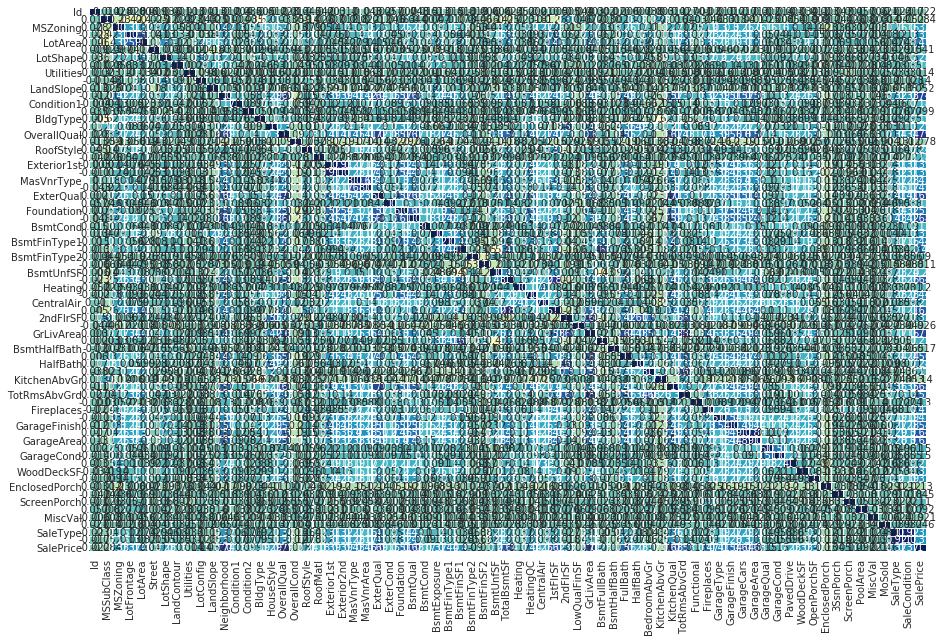

In [50]:
# Correlation Plot/Heat Map
plt.figure(figsize=(15,10))
sns.heatmap(df_data.corr().round(3), cmap='YlGnBu', annot=True, cbar=False, linewidth=.1);

In [51]:
stop

NameError: name 'stop' is not defined

# Train-Test Split

In [ ]:
def train_test_splits(df,target,identifer_cols,split_ratio):
    x = df.drop(identifer_cols,axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split_ratio, random_state=42)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_splits(df_data,Target,identifer_cols,0.2)

In [ ]:
X_train.head()

# Feature selection 

# Filter Methods

# Univariate Feature Selection Regression

In [ ]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import  mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
def univariate_selecetion(indep,dep,percentile_value):
    univariate = f_regression(indep, dep)
    # Capture P values in a series
    univariate = pd.Series(univariate[1])
    univariate.index = indep.columns
    univariate.sort_values(ascending=False, inplace=True)
    univariate.sort_values(ascending=False).plot.bar(figsize=(20,8))
    k_percentile_features = SelectPercentile(f_regression, percentile=percentile_value).fit(indep, dep)
    dep_col = X_train.columns[k_percentile_features.get_support()].to_list()
    return dep_col

In [ ]:
dep_col_u = univariate_selecetion(X_train,y_train,40)

In [ ]:
dep_col_u

In [ ]:
def mutual_info_regression_selecetion(indep,dep,percentile_value):
    mutual_info = mutual_info_regression(indep, dep)
    mi_series = pd.Series(mutual_info)
    mi_series.index = indep.columns
    mi_series.sort_values(ascending=False)
    mi_series.sort_values(ascending=False).plot.bar(figsize=(20,8))
    k_percentile_features = SelectPercentile(mutual_info_regression, percentile=percentile_value).fit(indep, dep)
    dep_col = X_train.columns[k_percentile_features.get_support()].to_list()
    return dep_col

In [ ]:
dep_col_m = mutual_info_regression_selecetion(X_train,y_train,40)

In [ ]:
dep_col_m

# Wrapper Methods

# Step Forward Feature Selection

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
def Forward_Feature_Selection(indep,dep,Metric,k_fea):
    sfs1 = SFS(RandomForestRegressor(),k_features=k_fea,forward=True,floating=False,verbose=2,scoring= Metric,cv=3)
    sfs1 = sfs1.fit(np.array(indep), dep)
    dep_col = indep.columns[list(sfs1.k_feature_idx_)]
    return dep_col

In [ ]:
dep_col_ffs = Forward_Feature_Selection(X_train,y_train,"r2",20)

In [ ]:
dep_col_ffs

# Step backward feature selection

In [ ]:
def Backward_Feature_Selection(indep,dep,Metric,k_fea):
    sfs1 = SFS(RandomForestRegressor(),k_features=k_fea,forward=False,floating=False,verbose=2,scoring= Metric,cv=3)
    sfs1 = sfs1.fit(np.array(indep), dep)
    dep_col = indep.columns[list(sfs1.k_feature_idx_)]
    return dep_col

In [ ]:
dep_col_bfs = Backward_Feature_Selection(X_train,y_train,"r2",20)

In [ ]:
dep_col_bfs

# Scale Data (In Order To Normalize)

In [ ]:
from sklearn.preprocessing import StandardScaler
minmax_scaler = StandardScaler()

minmax_scaler.fit(X_train)
X_train_scaled = pd.DataFrame(minmax_scaler.transform(X_train), columns=X_train.columns)

minmax_scaler.fit(X_test)
X_test_scaled = pd.DataFrame(minmax_scaler.transform(X_test), columns=X_test.columns)

# Model 

# Base 1

In [ ]:
import statsmodels.api as sm
X_endog1 = sm.add_constant(X_test[dep_col_u])
res = sm.OLS(y_test, X_endog1)
res.fit().summary()

In [ ]:
X_endog2 = sm.add_constant(X_test[dep_col_m])
res = sm.OLS(y_test, X_endog2)
res.fit().summary()

In [ ]:
X_endog3 = sm.add_constant(X_test[dep_col_ffs])
res = sm.OLS(y_test, X_endog3)
res.fit().summary()

In [ ]:
X_endog4 = sm.add_constant(X_test[dep_col_bfs])
res = sm.OLS(y_test, X_endog4)
res.fit().summary()